# Q-learning with Function Approximation for Time Series Anomaly Detection (RNN n-n, boosted binary tree)
RNN n-n means the function approximator is basically a neural network model with n dimensional inputs and n dimensional output. In this file, we made the following changes.

1. Use binary tree to estimate the action-value function in order to provide more accurate training dataset.

## Import the Library

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import sys
import os
import time

import tensorflow as tf

from tensorflow.contrib import rnn
from mpl_toolkits.mplot3d import axes3d
from collections import deque, namedtuple

# import the library in the sub-folder env
from env.time_series_repo_ext import EnvTimeSeriesfromRepo

In [2]:
# macros for running q-learning
DATAFIXED = 0           # whether target at a single time series dataset

EPISODES = 500          # number of episodes for training
DISCOUNT_FACTOR = 0.5   # reward discount factor [0,1]
EPSILON = 0.5           # epsilon-greedy method parameter for action selection
EPSILON_DECAY = 1.00    # epsilon-greedy method decay parameter

NOT_ANOMALY = 0
ANOMALY = 1

action_space = [NOT_ANOMALY, ANOMALY]
action_space_n = len(action_space)

n_steps = 25        # size of the slide window for SLIDE_WINDOW state and reward functions
n_input_dim = 2     # dimension of the input for a LSTM cell
n_hidden_dim = 64   # dimension of the hidden state in LSTM cell

## Q-learning: State Function & Reward Function

In [ ]:
# Reward Values
TP_Value = 5
TN_Value = 1
FP_Value = -1
FN_Value = -5

In [3]:
# The state function returns a vector composing of n_steps of n_input_dim data instances:
# e.g., [[x_1, f_1], [x_2, f_2], ..., [x_t, f_t]] of shape (n_steps, n_input_dim)
# x_t is the new data instance. t here is equal to n_steps

def RNNBinaryStateFuc(timeseries, timeseries_curser, previous_state=[], action=None):
    if timeseries_curser == n_steps:
        state = []
        for i in range(timeseries_curser):
            state.append([timeseries['value'][i], 0])
        
        state.pop(0)
        state.append([timeseries['value'][timeseries_curser], 1])
        
        return np.array(state, dtype='float32')
    
    if timeseries_curser > n_steps:
        state0 = np.concatenate((previous_state[1:n_steps],
                                 [[timeseries['value'][timeseries_curser], 0]]))
        state1 = np.concatenate((previous_state[1:n_steps],
                                 [[timeseries['value'][timeseries_curser], 1]]))
    
        return np.array([state0, state1], dtype='float32')
    
# Also, because we use binary tree here, the reward function returns a list of rewards for each action
def RNNBinaryRewardFuc(timeseries, timeseries_curser, action=0):
    if timeseries_curser >= n_steps:
        if timeseries['anomaly'][timeseries_curser] == 0:
            return [TN_Value, FP_Value]

        if timeseries['anomaly'][timeseries_curser] == 1:
            return [FN_Value, TP_Value]
    else:
        return [0,0]

## Q-learning: Q Function Approximator

In [4]:
class Q_Estimator_Nonlinear():
    """
    Action-Value Function Approximator Q(s,a) with Tensorflow RNN.
    Note: The Recurrent Neural Network is used here !
    """
    
    def __init__(self, learning_rate=np.float32(0.01), scope="Q_Estimator_Nonlinear", summaries_dir=None):
        self.scope = scope
        self.summary_writer = None
        
        with tf.variable_scope(scope):
            # tf Graph input
            # The input to the rnn is typically of the shape:
            # [batch_size, n_steps, n_input_dim]
            # RNN requires the data of the shape:
            # n_steps tensors of [batch_size, n_input_dim]
            self.state = tf.placeholder(shape=[None, n_steps, n_input_dim],
                                        dtype=tf.float32, name = "state")
            self.target = tf.placeholder(shape=[None, action_space_n],
                                         dtype=tf.float32, name = "target")
            
            # Define weights
            self.weights = {
                'out': tf.Variable(tf.random_normal([n_hidden_dim, action_space_n]))
            }
            self.biases = {
                'out': tf.Variable(tf.random_normal([action_space_n]))
            }
            
            self.state_unstack = tf.unstack(self.state, n_steps, 1)

            # Define a lstm cell with tensorflow
            lstm_cell = rnn.BasicLSTMCell(n_hidden_dim, forget_bias=1.0)

            # Get lstm cell output
            self.outputs, self.states = rnn.static_rnn(lstm_cell, 
                                                       self.state_unstack, 
                                                       dtype=tf.float32)

            # Linear activation, using rnn inner loop last output
            self.action_values = tf.matmul(self.outputs[-1], self.weights['out']) + self.biases['out']
            
            # Loss and train op
            self.losses = tf.squared_difference(self.action_values, self.target)
            self.loss = tf.reduce_mean(self.losses)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss, 
                                                    global_step=tf.contrib.framework.get_global_step())
            
            # Summaries for Tensorboard
            self.summaries = tf.summary.merge([
                tf.summary.histogram("loss_hist", self.losses),
                tf.summary.scalar("loss", self.loss),
                tf.summary.histogram("q_values_hist", self.action_values),
                tf.summary.scalar("q_value", tf.reduce_max(self.action_values))
            ])
    
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_values, {self.state: state})

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state, self.target: target}
        summaries, global_step, _ = sess.run([self.summaries, tf.contrib.framework.get_global_step(),
                                              self.train_op], feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return

In [5]:
def copy_model_parameters(sess, estimator1, estimator2):
    """
    Copies the model parameters of one estimator to another.

    Args:
      sess: Tensorflow session instance
      estimator1: Estimator to copy the paramters from
      estimator2: Estimator to copy the parameters to
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)

    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)

    sess.run(update_ops)

## Q-learning: Learning & other Functions

In [6]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action. float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation, epsilon):
        A = np.ones(nA, dtype='float32') * epsilon / nA
        q_values = estimator.predict(state=[observation])
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
def q_learning(env,
               qlearn_estimator,
               target_estimator,
               num_episodes,
               num_epoches,
               replay_memory_size=500000,
               replay_memory_init_size=50000,
               experiment_dir='./log/',
               update_target_estimator_every=10000,
               discount_factor=0.99,
               epsilon_start=1.0,
               epsilon_end=0.1,
               epsilon_decay_steps=500000,
               batch_size=512,
               test=0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: The environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        NULL
    """ 
    # 1. Define some useful variable
    # To memory
    Transition = namedtuple("Transition", ["state", "reward", "next_state", "done"])
    
    # The replay memory
    replay_memory = []
    
    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # Load a previous checkpoint if we find one
    saver = tf.train.Saver()
    
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
        if test:
            return
    
    # Get the time step
    total_t = sess.run(tf.contrib.framework.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(
        qlearn_estimator,
        env.action_space_n)
    
    
    # 2. Populate the replay memory with initial experience
    popu_time = time.time()
    
    state = env.reset()
    for i in range(replay_memory_init_size):
        action_probs = policy(state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        next_state, reward, done, _ = env.step(action)
        
        replay_memory.append(Transition(state, reward, next_state, done))
        
        if done:
            state = env.reset()
        else:
            state = next_state[action]
            
    popu_time = time.time() - popu_time
    print("Populating replay memory with time {}".format(popu_time))
    
    
    # 3. Start the main loop
    for i_episode in range(num_episodes):     
        # Save the current checkpoint   
        if i_episode%50 == 49:
            print("Save checkpoint in episode {}/{}".format(i_episode + 1, num_episodes))
            saver.save(tf.get_default_session(), checkpoint_path)
        
        
        per_loop_time1 = time.time()
        
        # Reset the environment
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():    
            # 3.1 Some Preprocess
            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]
            
            # 3.2 The main work
            # Choose an action to take
            action_probs = policy(state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # 3.3 Control replay memory
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)
                
            replay_memory.append(Transition(state, reward, next_state, done))
            
            if done:
                break
            
            state = next_state[action]
        
        
        per_loop_time2 = time.time()
                
        # Update the model
        for i_epoch in range(num_epoches):
            # Add epsilon to Tensorboard
            if qlearn_estimator.summary_writer:
                episode_summary = tf.Summary()
                qlearn_estimator.summary_writer.add_summary(episode_summary, total_t)

            # Update the target estimator
            if total_t % update_target_estimator_every == 0:
                copy_model_parameters(sess, qlearn_estimator, target_estimator)
                print("\nCopied model parameters to target network.\n")
                
            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
            
            if discount_factor > 0:
            # Calculate q values and targets
                next_states_batch = np.squeeze(np.split(next_states_batch, 2, axis=1))
                next_states_batch0 = next_states_batch[0]
                next_states_batch1 = next_states_batch[1]

                q_values_next0 = target_estimator.predict(state=next_states_batch0)
                q_values_next1 = target_estimator.predict(state=next_states_batch1)

                targets_batch = reward_batch + (discount_factor * 
                                                np.stack((np.amax(q_values_next0, axis=1), 
                                                          np.amax(q_values_next1, axis=1)), 
                                                         axis=-1))
            else:
                targets_batch = reward_batch

            # Perform gradient descent update
            qlearn_estimator.update(state=states_batch, target=targets_batch.astype(np.float32))
            
            total_t += 1
        
        # Print out which step we're on, useful for debugging.
        per_loop_time_popu = per_loop_time2 - per_loop_time1
        per_loop_time_updt = time.time() - per_loop_time2
        print("Global step {} @ Episode {}/{}, time: {} + {}"
              .format(total_t, i_episode + 1, num_episodes, per_loop_time_popu, per_loop_time_updt))
    return

In [8]:
def q_learning_validator(env, estimator, num_episodes, record_dir=None, plot=1):
    """
    With 1) the trained estimator of Q(s,a) action-value function, i.e., estimator
         2) the known envivronment, i.e., env
         
    Test the validity of the estimator in the application of time series anomaly detection.
    
    Args:
        env: The environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
    
    Returns:
        Statistics
    """
    if record_dir:
        rec_file = open('./{}'.format(record_dir), 'wb')
        rec_writer = csv.writer(rec_file)
    
    for i_episode in range(num_episodes):
        print("Episode {}/{}".format(i_episode + 1, num_episodes))
            
        state_rec = []
        action_rec = []
        reward_rec = []
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, env.action_space_n)
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():            
            # Choose an action to take
            action_probs = policy(state, 0)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Record the statistics
            state_rec.append(state[len(state)-1][0])
            action_rec.append(action)
            reward_rec.append(reward[action])
            
            if done:
                break
                
            state = next_state[action]
        
        # Search over reward_rec to correct the rewards
        # 1) If FN happend within a small range of TP (miss alarm very closer to reported anomaly), correct it
        # 2) If FP happend within a small range of TP (false alarm very close to the reported anomaly), correct it
        RNG = 5
        for i in range(len(reward_rec)):
            if reward_rec[i] < 0:
                low_range = max(0,i-RNG)
                up_range = min(i+RNG+1,len(reward_rec))
                r = reward_rec[low_range:up_range]
                if r.count(TP_Value) > 0:
                    reward_rec[i] = -reward_rec[i]
    
        # Plot the result for each episode
        if plot:
            f, axarr = plt.subplots(3, sharex=True)
            axarr[0].plot(state_rec)
            axarr[0].set_title('Time Series')
            axarr[1].plot(action_rec, color='g')
            axarr[1].set_title('Action')
            axarr[2].plot(reward_rec, color='r')
            axarr[2].set_title('Reward')
            plt.show()
        
        # Calculate the accuracy F1-score = 2*((precison*recall)/(precison+recall))
        # precision = tp / (tp+fp)
        # recall = tp / (tp+fn)
        tp = reward_rec.count(TP_Value)
        fp = reward_rec.count(FP_Value)
        fn = reward_rec.count(FN_Value)
        precision = (tp+1)/float(tp+fp+1)
        recall = (tp+1)/float(tp+fn+1)
        f1 = 2*((precision*recall)/(precision+recall))
        
        if record_dir:
            rec_writer.writerow([f1])
            
        print("Precision:{}, Recall:{}, F1-score:{} (f1 wrote to file)".format(precision, recall, f1))

    if record_dir:        
        rec_file.close()
    
    return

## Train the Action-Value Function Q(s,a) with Q-learning
1. Init the Q(s,a) action-value function estimator
2. Train the estimator with Q-learning

This training process uses Yahoo benchmark datasets (remember to make sure the code in time_series_repo_ext.py is ).

Populating replay memory with time 71.1040360928

Copied model parameters to target network.

Global step 10 @ Episode 1/2000, time: 1.97617101669 + 0.969247102737

Copied model parameters to target network.

Global step 20 @ Episode 2/2000, time: 1.99596786499 + 0.794588088989

Copied model parameters to target network.

Global step 30 @ Episode 3/2000, time: 1.9705350399 + 0.838788986206

Copied model parameters to target network.

Global step 40 @ Episode 4/2000, time: 2.02964305878 + 0.795149087906

Copied model parameters to target network.

Global step 50 @ Episode 5/2000, time: 2.09318804741 + 1.0012178421

Copied model parameters to target network.

Global step 60 @ Episode 6/2000, time: 2.08700895309 + 0.822588920593

Copied model parameters to target network.

Global step 70 @ Episode 7/2000, time: 2.23378014565 + 0.902838945389

Copied model parameters to target network.

Global step 80 @ Episode 8/2000, time: 2.02652096748 + 1.0317940712

Copied model parameters to target n


Copied model parameters to target network.

Global step 710 @ Episode 71/2000, time: 2.00262618065 + 0.798799991608

Copied model parameters to target network.

Global step 720 @ Episode 72/2000, time: 1.95062708855 + 0.808332920074

Copied model parameters to target network.

Global step 730 @ Episode 73/2000, time: 1.95973706245 + 0.810544013977

Copied model parameters to target network.

Global step 740 @ Episode 74/2000, time: 1.97549319267 + 0.811420917511

Copied model parameters to target network.

Global step 750 @ Episode 75/2000, time: 1.94093990326 + 0.79291009903

Copied model parameters to target network.

Global step 760 @ Episode 76/2000, time: 1.94904899597 + 0.812699794769

Copied model parameters to target network.

Global step 770 @ Episode 77/2000, time: 1.94915819168 + 0.795295953751

Copied model parameters to target network.

Global step 780 @ Episode 78/2000, time: 1.968282938 + 0.803030014038

Copied model parameters to target network.

Global step 790 @ Epis

Global step 1400 @ Episode 140/2000, time: 2.30020403862 + 0.878854036331

Copied model parameters to target network.

Global step 1410 @ Episode 141/2000, time: 2.41971802711 + 0.857686042786

Copied model parameters to target network.

Global step 1420 @ Episode 142/2000, time: 2.30511903763 + 0.825796842575

Copied model parameters to target network.

Global step 1430 @ Episode 143/2000, time: 2.28315711021 + 0.859225034714

Copied model parameters to target network.

Global step 1440 @ Episode 144/2000, time: 2.33833789825 + 0.86493396759

Copied model parameters to target network.

Global step 1450 @ Episode 145/2000, time: 2.2832839489 + 0.822660923004

Copied model parameters to target network.

Global step 1460 @ Episode 146/2000, time: 2.29543781281 + 0.866742134094

Copied model parameters to target network.

Global step 1470 @ Episode 147/2000, time: 2.3416697979 + 0.861709117889

Copied model parameters to target network.

Global step 1480 @ Episode 148/2000, time: 2.306156


Copied model parameters to target network.

Global step 2090 @ Episode 209/2000, time: 2.32445907593 + 0.839752912521

Copied model parameters to target network.

Global step 2100 @ Episode 210/2000, time: 2.30833888054 + 0.840005159378

Copied model parameters to target network.

Global step 2110 @ Episode 211/2000, time: 2.31495594978 + 0.909058094025

Copied model parameters to target network.

Global step 2120 @ Episode 212/2000, time: 2.29755592346 + 0.843147993088

Copied model parameters to target network.

Global step 2130 @ Episode 213/2000, time: 2.36475276947 + 0.840260028839

Copied model parameters to target network.

Global step 2140 @ Episode 214/2000, time: 2.31973099709 + 0.814718961716

Copied model parameters to target network.

Global step 2150 @ Episode 215/2000, time: 2.37012887001 + 0.850979089737

Copied model parameters to target network.

Global step 2160 @ Episode 216/2000, time: 2.28424406052 + 0.838050127029

Copied model parameters to target network.

Glo


Copied model parameters to target network.

Global step 2780 @ Episode 278/2000, time: 2.29240584373 + 0.868144035339

Copied model parameters to target network.

Global step 2790 @ Episode 279/2000, time: 2.30341696739 + 0.917363882065

Copied model parameters to target network.

Global step 2800 @ Episode 280/2000, time: 2.38991713524 + 0.833150863647

Copied model parameters to target network.

Global step 2810 @ Episode 281/2000, time: 2.29972505569 + 0.868113040924

Copied model parameters to target network.

Global step 2820 @ Episode 282/2000, time: 2.31718111038 + 0.871051073074

Copied model parameters to target network.

Global step 2830 @ Episode 283/2000, time: 2.65314006805 + 0.882816791534

Copied model parameters to target network.

Global step 2840 @ Episode 284/2000, time: 2.35870409012 + 0.845458030701

Copied model parameters to target network.

Global step 2850 @ Episode 285/2000, time: 2.34857797623 + 0.878950834274

Copied model parameters to target network.

Glo


Copied model parameters to target network.

Global step 3470 @ Episode 347/2000, time: 3.11178684235 + 0.897296190262

Copied model parameters to target network.

Global step 3480 @ Episode 348/2000, time: 3.00855708122 + 0.893590927124

Copied model parameters to target network.

Global step 3490 @ Episode 349/2000, time: 2.99789881706 + 0.893155097961
Save checkpoint in episode 350/2000

Copied model parameters to target network.

Global step 3500 @ Episode 350/2000, time: 2.97242093086 + 0.854051113129

Copied model parameters to target network.

Global step 3510 @ Episode 351/2000, time: 3.06449389458 + 0.848597049713

Copied model parameters to target network.

Global step 3520 @ Episode 352/2000, time: 3.01729917526 + 0.852416992188

Copied model parameters to target network.

Global step 3530 @ Episode 353/2000, time: 3.06188106537 + 0.869335889816

Copied model parameters to target network.

Global step 3540 @ Episode 354/2000, time: 3.09647297859 + 0.857491970062

Copied mode


Copied model parameters to target network.

Global step 4160 @ Episode 416/2000, time: 3.00676584244 + 0.903151988983

Copied model parameters to target network.

Global step 4170 @ Episode 417/2000, time: 2.96504306793 + 0.899835824966

Copied model parameters to target network.

Global step 4180 @ Episode 418/2000, time: 3.00239706039 + 0.903169870377

Copied model parameters to target network.

Global step 4190 @ Episode 419/2000, time: 2.98290395737 + 0.860435009003

Copied model parameters to target network.

Global step 4200 @ Episode 420/2000, time: 3.13003611565 + 0.892067909241

Copied model parameters to target network.

Global step 4210 @ Episode 421/2000, time: 3.02749705315 + 0.892223834991

Copied model parameters to target network.

Global step 4220 @ Episode 422/2000, time: 2.97081303596 + 0.862900018692

Copied model parameters to target network.

Global step 4230 @ Episode 423/2000, time: 3.00288105011 + 0.89605307579

Copied model parameters to target network.

Glob


Copied model parameters to target network.

Global step 4850 @ Episode 485/2000, time: 2.96964502335 + 0.954275846481

Copied model parameters to target network.

Global step 4860 @ Episode 486/2000, time: 2.96746897697 + 0.882390022278

Copied model parameters to target network.

Global step 4870 @ Episode 487/2000, time: 2.99491620064 + 0.924013853073

Copied model parameters to target network.

Global step 4880 @ Episode 488/2000, time: 3.15967392921 + 0.924777030945

Copied model parameters to target network.

Global step 4890 @ Episode 489/2000, time: 3.00411701202 + 0.911265850067

Copied model parameters to target network.

Global step 4900 @ Episode 490/2000, time: 2.9812579155 + 0.879076004028

Copied model parameters to target network.

Global step 4910 @ Episode 491/2000, time: 3.02433109283 + 0.90450501442

Copied model parameters to target network.

Global step 4920 @ Episode 492/2000, time: 2.98207306862 + 0.913823127747

Copied model parameters to target network.

Globa


Copied model parameters to target network.

Global step 5540 @ Episode 554/2000, time: 3.54550409317 + 0.931673765182

Copied model parameters to target network.

Global step 5550 @ Episode 555/2000, time: 3.53404402733 + 0.930708885193

Copied model parameters to target network.

Global step 5560 @ Episode 556/2000, time: 3.53932094574 + 0.920951128006

Copied model parameters to target network.

Global step 5570 @ Episode 557/2000, time: 3.55053782463 + 0.920643091202

Copied model parameters to target network.

Global step 5580 @ Episode 558/2000, time: 3.51911687851 + 0.930740118027

Copied model parameters to target network.

Global step 5590 @ Episode 559/2000, time: 3.54459786415 + 0.920380115509

Copied model parameters to target network.

Global step 5600 @ Episode 560/2000, time: 3.58036899567 + 0.933352231979

Copied model parameters to target network.

Global step 5610 @ Episode 561/2000, time: 3.52503204346 + 0.866816997528

Copied model parameters to target network.

Glo


Copied model parameters to target network.

Global step 6230 @ Episode 623/2000, time: 3.55249285698 + 0.870157003403

Copied model parameters to target network.

Global step 6240 @ Episode 624/2000, time: 3.55435299873 + 0.876564025879

Copied model parameters to target network.

Global step 6250 @ Episode 625/2000, time: 3.53378200531 + 0.877330064774

Copied model parameters to target network.

Global step 6260 @ Episode 626/2000, time: 3.54163408279 + 0.966441869736

Copied model parameters to target network.

Global step 6270 @ Episode 627/2000, time: 3.5807800293 + 0.872053861618

Copied model parameters to target network.

Global step 6280 @ Episode 628/2000, time: 3.53655982018 + 0.889481067657

Copied model parameters to target network.

Global step 6290 @ Episode 629/2000, time: 3.55496811867 + 0.875683784485

Copied model parameters to target network.

Global step 6300 @ Episode 630/2000, time: 3.55365991592 + 0.878833055496

Copied model parameters to target network.

Glob


Copied model parameters to target network.

Global step 6920 @ Episode 692/2000, time: 3.56008887291 + 0.882905006409

Copied model parameters to target network.

Global step 6930 @ Episode 693/2000, time: 3.50770688057 + 0.909951210022

Copied model parameters to target network.

Global step 6940 @ Episode 694/2000, time: 3.54028296471 + 0.884500026703

Copied model parameters to target network.

Global step 6950 @ Episode 695/2000, time: 3.52301287651 + 0.882434129715

Copied model parameters to target network.

Global step 6960 @ Episode 696/2000, time: 3.55284905434 + 0.882201910019

Copied model parameters to target network.

Global step 6970 @ Episode 697/2000, time: 3.57609200478 + 0.908137083054

Copied model parameters to target network.

Global step 6980 @ Episode 698/2000, time: 3.0011100769 + 0.900339841843

Copied model parameters to target network.

Global step 6990 @ Episode 699/2000, time: 3.00514411926 + 0.871834993362
Save checkpoint in episode 700/2000

Copied model

Global step 7600 @ Episode 760/2000, time: 2.96722984314 + 0.973461151123

Copied model parameters to target network.

Global step 7610 @ Episode 761/2000, time: 2.96867990494 + 0.916835069656

Copied model parameters to target network.

Global step 7620 @ Episode 762/2000, time: 2.97358703613 + 0.955475091934

Copied model parameters to target network.

Global step 7630 @ Episode 763/2000, time: 2.99391198158 + 0.964543104172

Copied model parameters to target network.

Global step 7640 @ Episode 764/2000, time: 3.04303002357 + 0.89714217186

Copied model parameters to target network.

Global step 7650 @ Episode 765/2000, time: 2.97668409348 + 0.87415099144

Copied model parameters to target network.

Global step 7660 @ Episode 766/2000, time: 2.9824051857 + 0.875696897507

Copied model parameters to target network.

Global step 7670 @ Episode 767/2000, time: 2.97989606857 + 0.947245836258

Copied model parameters to target network.

Global step 7680 @ Episode 768/2000, time: 2.977176

Global step 8290 @ Episode 829/2000, time: 3.00275802612 + 0.91162109375

Copied model parameters to target network.

Global step 8300 @ Episode 830/2000, time: 2.9811000824 + 0.905306816101

Copied model parameters to target network.

Global step 8310 @ Episode 831/2000, time: 2.96928596497 + 0.903226137161

Copied model parameters to target network.

Global step 8320 @ Episode 832/2000, time: 3.04761314392 + 0.901275873184

Copied model parameters to target network.

Global step 8330 @ Episode 833/2000, time: 2.95323586464 + 0.892423152924

Copied model parameters to target network.

Global step 8340 @ Episode 834/2000, time: 2.96885609627 + 0.940618991852

Copied model parameters to target network.

Global step 8350 @ Episode 835/2000, time: 2.97612285614 + 0.893191099167

Copied model parameters to target network.

Global step 8360 @ Episode 836/2000, time: 2.97003412247 + 0.88981294632

Copied model parameters to target network.

Global step 8370 @ Episode 837/2000, time: 3.008560

Global step 8980 @ Episode 898/2000, time: 3.53053712845 + 0.942971944809

Copied model parameters to target network.

Global step 8990 @ Episode 899/2000, time: 3.53765797615 + 0.909515857697
Save checkpoint in episode 900/2000

Copied model parameters to target network.

Global step 9000 @ Episode 900/2000, time: 3.55238986015 + 0.962343931198

Copied model parameters to target network.

Global step 9010 @ Episode 901/2000, time: 3.51455807686 + 1.02454590797

Copied model parameters to target network.

Global step 9020 @ Episode 902/2000, time: 3.49875712395 + 0.943591833115

Copied model parameters to target network.

Global step 9030 @ Episode 903/2000, time: 3.58155488968 + 0.943073034286

Copied model parameters to target network.

Global step 9040 @ Episode 904/2000, time: 3.51240992546 + 0.932240009308

Copied model parameters to target network.

Global step 9050 @ Episode 905/2000, time: 3.50142407417 + 0.925972938538

Copied model parameters to target network.

Global step 9


Copied model parameters to target network.

Global step 9670 @ Episode 967/2000, time: 3.54642891884 + 0.982168912888

Copied model parameters to target network.

Global step 9680 @ Episode 968/2000, time: 3.55541205406 + 0.962502002716

Copied model parameters to target network.

Global step 9690 @ Episode 969/2000, time: 3.50857806206 + 0.947624921799

Copied model parameters to target network.

Global step 9700 @ Episode 970/2000, time: 3.52329111099 + 0.968893051147

Copied model parameters to target network.

Global step 9710 @ Episode 971/2000, time: 3.52910518646 + 0.961516857147

Copied model parameters to target network.

Global step 9720 @ Episode 972/2000, time: 3.50732588768 + 1.00732517242

Copied model parameters to target network.

Global step 9730 @ Episode 973/2000, time: 3.50568199158 + 0.957459211349

Copied model parameters to target network.

Global step 9740 @ Episode 974/2000, time: 3.53693604469 + 0.958877801895

Copied model parameters to target network.

Glob

Global step 10350 @ Episode 1035/2000, time: 3.53333902359 + 0.965688943863

Copied model parameters to target network.

Global step 10360 @ Episode 1036/2000, time: 3.55134510994 + 0.964470863342

Copied model parameters to target network.

Global step 10370 @ Episode 1037/2000, time: 3.53039598465 + 0.968380212784

Copied model parameters to target network.

Global step 10380 @ Episode 1038/2000, time: 3.57617807388 + 1.02059006691

Copied model parameters to target network.

Global step 10390 @ Episode 1039/2000, time: 3.53011393547 + 0.973086118698

Copied model parameters to target network.

Global step 10400 @ Episode 1040/2000, time: 3.52452301979 + 0.976238965988

Copied model parameters to target network.

Global step 10410 @ Episode 1041/2000, time: 3.58191394806 + 0.970167160034

Copied model parameters to target network.

Global step 10420 @ Episode 1042/2000, time: 3.53490614891 + 0.976194858551

Copied model parameters to target network.

Global step 10430 @ Episode 1043/


Copied model parameters to target network.

Global step 11030 @ Episode 1103/2000, time: 3.08417582512 + 0.964421033859

Copied model parameters to target network.

Global step 11040 @ Episode 1104/2000, time: 2.99653196335 + 0.98076915741

Copied model parameters to target network.

Global step 11050 @ Episode 1105/2000, time: 2.98976111412 + 1.01898479462

Copied model parameters to target network.

Global step 11060 @ Episode 1106/2000, time: 2.96834206581 + 0.979616880417

Copied model parameters to target network.

Global step 11070 @ Episode 1107/2000, time: 2.99266600609 + 0.986133098602

Copied model parameters to target network.

Global step 11080 @ Episode 1108/2000, time: 3.08913207054 + 0.980813026428

Copied model parameters to target network.

Global step 11090 @ Episode 1109/2000, time: 3.02138996124 + 0.978420972824

Copied model parameters to target network.

Global step 11100 @ Episode 1110/2000, time: 3.01394414902 + 0.969423055649

Copied model parameters to target


Copied model parameters to target network.

Global step 11710 @ Episode 1171/2000, time: 3.27294182777 + 0.985486984253

Copied model parameters to target network.

Global step 11720 @ Episode 1172/2000, time: 3.23213386536 + 0.999186992645

Copied model parameters to target network.

Global step 11730 @ Episode 1173/2000, time: 3.20535492897 + 1.10732603073

Copied model parameters to target network.

Global step 11740 @ Episode 1174/2000, time: 3.37172698975 + 1.09499597549

Copied model parameters to target network.

Global step 11750 @ Episode 1175/2000, time: 3.09025788307 + 1.06078219414

Copied model parameters to target network.

Global step 11760 @ Episode 1176/2000, time: 3.20991516113 + 1.08768796921

Copied model parameters to target network.

Global step 11770 @ Episode 1177/2000, time: 3.13063001633 + 1.06198215485

Copied model parameters to target network.

Global step 11780 @ Episode 1178/2000, time: 3.50267910957 + 1.03431391716

Copied model parameters to target net


Copied model parameters to target network.

Global step 12390 @ Episode 1239/2000, time: 3.56577587128 + 1.02351403236

Copied model parameters to target network.

Global step 12400 @ Episode 1240/2000, time: 3.84914302826 + 1.08922600746

Copied model parameters to target network.

Global step 12410 @ Episode 1241/2000, time: 3.78276515007 + 1.01445293427

Copied model parameters to target network.

Global step 12420 @ Episode 1242/2000, time: 3.79107809067 + 1.0365550518

Copied model parameters to target network.

Global step 12430 @ Episode 1243/2000, time: 3.85633301735 + 1.08142995834

Copied model parameters to target network.

Global step 12440 @ Episode 1244/2000, time: 3.69582009315 + 1.00416398048

Copied model parameters to target network.

Global step 12450 @ Episode 1245/2000, time: 3.88281798363 + 1.05112099648

Copied model parameters to target network.

Global step 12460 @ Episode 1246/2000, time: 3.75398206711 + 0.997694015503

Copied model parameters to target netwo


Copied model parameters to target network.

Global step 13070 @ Episode 1307/2000, time: 3.7763569355 + 1.1403670311

Copied model parameters to target network.

Global step 13080 @ Episode 1308/2000, time: 3.65038609505 + 1.01241493225

Copied model parameters to target network.

Global step 13090 @ Episode 1309/2000, time: 3.6676402092 + 0.982181787491

Copied model parameters to target network.

Global step 13100 @ Episode 1310/2000, time: 3.59831786156 + 1.03742313385

Copied model parameters to target network.

Global step 13110 @ Episode 1311/2000, time: 3.93975996971 + 1.1282980442

Copied model parameters to target network.

Global step 13120 @ Episode 1312/2000, time: 3.69391703606 + 0.981086969376

Copied model parameters to target network.

Global step 13130 @ Episode 1313/2000, time: 3.59721493721 + 1.07068300247

Copied model parameters to target network.

Global step 13140 @ Episode 1314/2000, time: 4.02948212624 + 1.02258682251

Copied model parameters to target network


Copied model parameters to target network.

Global step 13750 @ Episode 1375/2000, time: 3.55536389351 + 0.984299898148

Copied model parameters to target network.

Global step 13760 @ Episode 1376/2000, time: 3.51341700554 + 0.984405040741

Copied model parameters to target network.

Global step 13770 @ Episode 1377/2000, time: 3.54658985138 + 1.03175020218

Copied model parameters to target network.

Global step 13780 @ Episode 1378/2000, time: 3.53864502907 + 0.988596916199

Copied model parameters to target network.

Global step 13790 @ Episode 1379/2000, time: 3.54224991798 + 0.988403081894

Copied model parameters to target network.

Global step 13800 @ Episode 1380/2000, time: 3.57190990448 + 0.986438989639

Copied model parameters to target network.

Global step 13810 @ Episode 1381/2000, time: 3.5187830925 + 0.982083082199

Copied model parameters to target network.

Global step 13820 @ Episode 1382/2000, time: 3.54833984375 + 0.99063706398

Copied model parameters to target 


Copied model parameters to target network.

Global step 14430 @ Episode 1443/2000, time: 3.00220799446 + 0.994112014771

Copied model parameters to target network.

Global step 14440 @ Episode 1444/2000, time: 2.98444604874 + 0.980303049088

Copied model parameters to target network.

Global step 14450 @ Episode 1445/2000, time: 2.97284793854 + 1.01240801811

Copied model parameters to target network.

Global step 14460 @ Episode 1446/2000, time: 2.97608089447 + 1.00699710846

Copied model parameters to target network.

Global step 14470 @ Episode 1447/2000, time: 3.00797200203 + 0.981476068497

Copied model parameters to target network.

Global step 14480 @ Episode 1448/2000, time: 3.06925296783 + 0.977036952972

Copied model parameters to target network.

Global step 14490 @ Episode 1449/2000, time: 2.99052095413 + 1.00952386856
Save checkpoint in episode 1450/2000

Copied model parameters to target network.

Global step 14500 @ Episode 1450/2000, time: 3.02689313889 + 0.97869491577

Global step 15100 @ Episode 1510/2000, time: 2.99797105789 + 0.992232084274

Copied model parameters to target network.

Global step 15110 @ Episode 1511/2000, time: 2.97996091843 + 0.973492145538

Copied model parameters to target network.

Global step 15120 @ Episode 1512/2000, time: 3.00313711166 + 0.960953950882

Copied model parameters to target network.

Global step 15130 @ Episode 1513/2000, time: 2.95203900337 + 0.972319126129

Copied model parameters to target network.

Global step 15140 @ Episode 1514/2000, time: 3.02746009827 + 1.0199649334

Copied model parameters to target network.

Global step 15150 @ Episode 1515/2000, time: 2.99034810066 + 0.976737976074

Copied model parameters to target network.

Global step 15160 @ Episode 1516/2000, time: 2.96467709541 + 0.986401081085

Copied model parameters to target network.

Global step 15170 @ Episode 1517/2000, time: 3.02101802826 + 0.984565019608

Copied model parameters to target network.

Global step 15180 @ Episode 1518/2


Copied model parameters to target network.

Global step 15780 @ Episode 1578/2000, time: 2.96611809731 + 0.992557048798

Copied model parameters to target network.

Global step 15790 @ Episode 1579/2000, time: 2.99513888359 + 1.05114603043

Copied model parameters to target network.

Global step 15800 @ Episode 1580/2000, time: 2.95984792709 + 0.969922065735

Copied model parameters to target network.

Global step 15810 @ Episode 1581/2000, time: 2.95888996124 + 1.02197694778

Copied model parameters to target network.

Global step 15820 @ Episode 1582/2000, time: 2.95951700211 + 1.01343584061

Copied model parameters to target network.

Global step 15830 @ Episode 1583/2000, time: 2.97546291351 + 0.999760150909

Copied model parameters to target network.

Global step 15840 @ Episode 1584/2000, time: 2.98588681221 + 0.983605146408

Copied model parameters to target network.

Global step 15850 @ Episode 1585/2000, time: 2.98636484146 + 0.986134052277

Copied model parameters to target 


Copied model parameters to target network.

Global step 16460 @ Episode 1646/2000, time: 5.25258207321 + 1.35178279877

Copied model parameters to target network.

Global step 16470 @ Episode 1647/2000, time: 3.80254793167 + 1.079433918

Copied model parameters to target network.

Global step 16480 @ Episode 1648/2000, time: 3.62989711761 + 1.04813504219

Copied model parameters to target network.

Global step 16490 @ Episode 1649/2000, time: 3.82539010048 + 1.11511182785
Save checkpoint in episode 1650/2000

Copied model parameters to target network.

Global step 16500 @ Episode 1650/2000, time: 5.29807305336 + 1.39756011963

Copied model parameters to target network.

Global step 16510 @ Episode 1651/2000, time: 4.02559995651 + 1.69206809998

Copied model parameters to target network.

Global step 16520 @ Episode 1652/2000, time: 3.69764900208 + 1.02740216255

Copied model parameters to target network.

Global step 16530 @ Episode 1653/2000, time: 3.62996816635 + 1.16829681396

Copi


Copied model parameters to target network.

Global step 17140 @ Episode 1714/2000, time: 3.71973896027 + 1.06192994118

Copied model parameters to target network.

Global step 17150 @ Episode 1715/2000, time: 3.90573477745 + 1.12474298477

Copied model parameters to target network.

Global step 17160 @ Episode 1716/2000, time: 3.80909585953 + 1.26594305038

Copied model parameters to target network.

Global step 17170 @ Episode 1717/2000, time: 4.01943087578 + 1.22926402092

Copied model parameters to target network.

Global step 17180 @ Episode 1718/2000, time: 3.86962795258 + 1.16851902008

Copied model parameters to target network.

Global step 17190 @ Episode 1719/2000, time: 4.40694904327 + 1.98119783401

Copied model parameters to target network.

Global step 17200 @ Episode 1720/2000, time: 4.31292510033 + 1.54526185989

Copied model parameters to target network.

Global step 17210 @ Episode 1721/2000, time: 4.71497988701 + 1.42117500305

Copied model parameters to target netwo

Global step 17820 @ Episode 1782/2000, time: 4.34835791588 + 1.30476021767

Copied model parameters to target network.

Global step 17830 @ Episode 1783/2000, time: 4.55807209015 + 1.2883810997

Copied model parameters to target network.

Global step 17840 @ Episode 1784/2000, time: 4.03715610504 + 1.30332398415

Copied model parameters to target network.

Global step 17850 @ Episode 1785/2000, time: 4.86705613136 + 1.3429479599

Copied model parameters to target network.

Global step 17860 @ Episode 1786/2000, time: 4.27936792374 + 1.06259202957

Copied model parameters to target network.

Global step 17870 @ Episode 1787/2000, time: 3.73427200317 + 1.25988411903

Copied model parameters to target network.

Global step 17880 @ Episode 1788/2000, time: 5.36032986641 + 1.54027795792

Copied model parameters to target network.

Global step 17890 @ Episode 1789/2000, time: 5.49467492104 + 1.5634329319

Copied model parameters to target network.

Global step 17900 @ Episode 1790/2000, time

Global step 18500 @ Episode 1850/2000, time: 3.04487609863 + 1.04561090469

Copied model parameters to target network.

Global step 18510 @ Episode 1851/2000, time: 3.03226113319 + 1.04472708702

Copied model parameters to target network.

Global step 18520 @ Episode 1852/2000, time: 3.1030318737 + 1.67298603058

Copied model parameters to target network.

Global step 18530 @ Episode 1853/2000, time: 3.7830119133 + 1.57139015198

Copied model parameters to target network.

Global step 18540 @ Episode 1854/2000, time: 3.25602602959 + 1.15054488182

Copied model parameters to target network.

Global step 18550 @ Episode 1855/2000, time: 3.3983669281 + 1.20707702637

Copied model parameters to target network.

Global step 18560 @ Episode 1856/2000, time: 3.65592002869 + 1.37398195267

Copied model parameters to target network.

Global step 18570 @ Episode 1857/2000, time: 1.77554988861 + 1.19066405296

Copied model parameters to target network.

Global step 18580 @ Episode 1858/2000, time


Copied model parameters to target network.

Global step 19190 @ Episode 1919/2000, time: 2.98988294601 + 1.03316712379

Copied model parameters to target network.

Global step 19200 @ Episode 1920/2000, time: 2.95684504509 + 1.0444419384

Copied model parameters to target network.

Global step 19210 @ Episode 1921/2000, time: 2.99795103073 + 1.03038215637

Copied model parameters to target network.

Global step 19220 @ Episode 1922/2000, time: 2.99366092682 + 1.04223895073

Copied model parameters to target network.

Global step 19230 @ Episode 1923/2000, time: 2.94737315178 + 1.03954005241

Copied model parameters to target network.

Global step 19240 @ Episode 1924/2000, time: 2.99741196632 + 1.05093598366

Copied model parameters to target network.

Global step 19250 @ Episode 1925/2000, time: 2.99404811859 + 1.03109502792

Copied model parameters to target network.

Global step 19260 @ Episode 1926/2000, time: 2.96038508415 + 1.04604482651

Copied model parameters to target networ

Global step 19870 @ Episode 1987/2000, time: 4.11295294762 + 1.05048799515

Copied model parameters to target network.

Global step 19880 @ Episode 1988/2000, time: 3.94797897339 + 2.00757694244

Copied model parameters to target network.

Global step 19890 @ Episode 1989/2000, time: 3.82536888123 + 1.10345196724

Copied model parameters to target network.

Global step 19900 @ Episode 1990/2000, time: 3.78192710876 + 1.44812989235

Copied model parameters to target network.

Global step 19910 @ Episode 1991/2000, time: 4.4039978981 + 1.63565707207

Copied model parameters to target network.

Global step 19920 @ Episode 1992/2000, time: 4.56067800522 + 1.31770086288

Copied model parameters to target network.

Global step 19930 @ Episode 1993/2000, time: 4.33825707436 + 1.29814195633

Copied model parameters to target network.

Global step 19940 @ Episode 1994/2000, time: 4.64746189117 + 1.29914212227

Copied model parameters to target network.

Global step 19950 @ Episode 1995/2000, ti

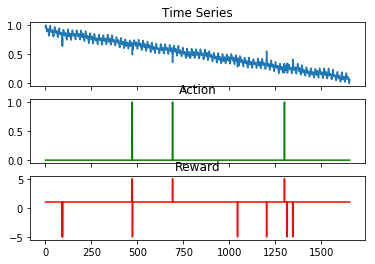

In [9]:
# percentage = ['0.2', '0.35', '0.65', '0.8']
percentage = [1]

for j in range(len(percentage)):
    # Where we save our checkpoints and graphs
    # exp_relative_dir = ['RNN Binary d0.9 s25 h64 b256 A1_partial_data_' + percentage[j], 'RNN Binary d0.9 s25 h64 b256 A2_partial_data_' + percentage[j],
    #                     'RNN Binary d0.9 s25 h64 b256 A3_partial_data_' + percentage[j], 'RNN Binary d0.9 s25 h64 b256 A4_partial_data_' + percentage[j]]
    exp_relative_dir = ['RNN Binary d0.9 s25 h64 b256 A1-4_all_data']
    
    # Which dataset we are targeting
    # dataset_dir = ['env/time_series_repo/A1Benchmark', 'env/time_series_repo/A2Benchmark',
    #                'env/time_series_repo/A3Benchmark', 'env/time_series_repo/A4Benchmark']
    dataset_dir = ['env/time_series_repo/']

    for i in range(len(dataset_dir)):

        env = EnvTimeSeriesfromRepo(dataset_dir[i])
        env.statefnc = RNNBinaryStateFuc
        env.rewardfnc = RNNBinaryRewardFuc
        env.timeseries_curser_init = n_steps
        env.datasetfix = DATAFIXED
        env.datasetrng = np.int32(env.datasetsize * float(percentage[j]))
        env.datasetidx = 0

        experiment_dir = os.path.abspath("./exp/{}".format(exp_relative_dir[i]))

        tf.reset_default_graph()

        global_step = tf.Variable(0, name="global_step", trainable=False)

        qlearn_estimator = Q_Estimator_Nonlinear(scope="qlearn", summaries_dir=experiment_dir)
        target_estimator = Q_Estimator_Nonlinear(scope="target")

        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        with sess.as_default():
            q_learning(env,
                       qlearn_estimator=qlearn_estimator,
                       target_estimator=target_estimator,
                       num_episodes=2000,
                       num_epoches=10,
                       experiment_dir=experiment_dir,
                       replay_memory_size=500000,
                       replay_memory_init_size=50000,
                       update_target_estimator_every=10,
                       epsilon_start=1.0,
                       epsilon_end=0.1,
                       epsilon_decay_steps=500000,
                       discount_factor=0.9,
                       batch_size=256,
                       test=0)

            q_learning_validator(env, qlearn_estimator, 1)

367
Episode 1/367


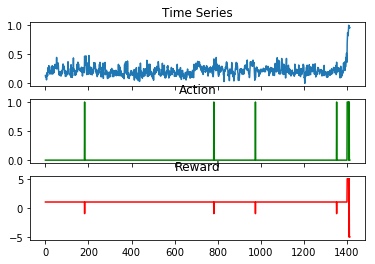

Episode 2/367


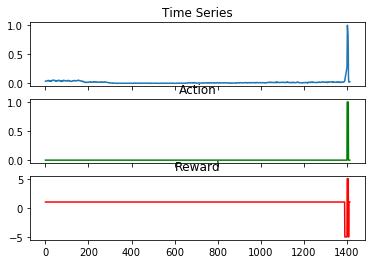

Episode 3/367


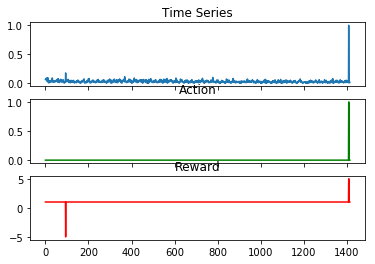

Episode 4/367


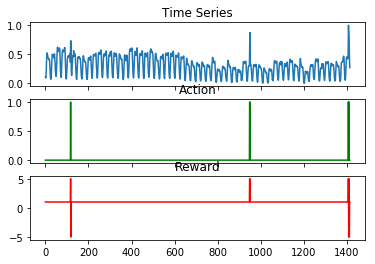

Episode 5/367


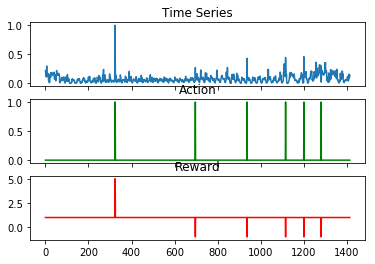

Episode 6/367


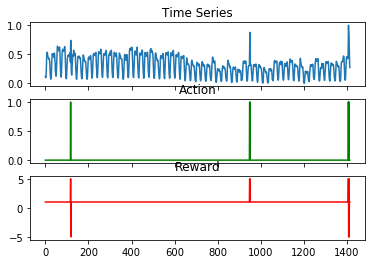

Episode 7/367


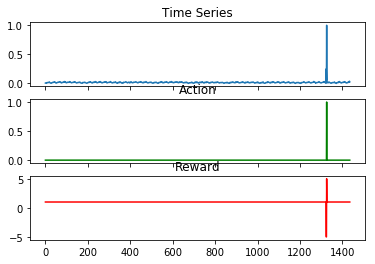

Episode 8/367


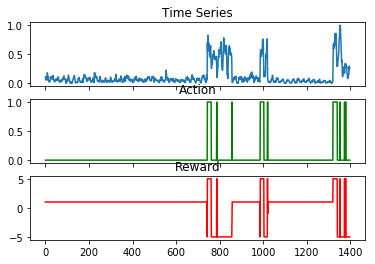

Episode 9/367


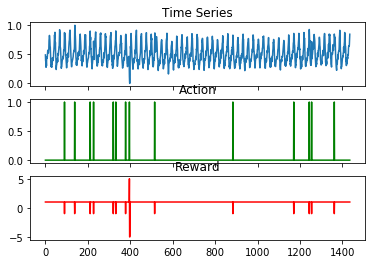

Episode 10/367


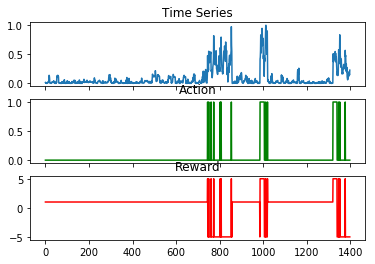

Episode 11/367


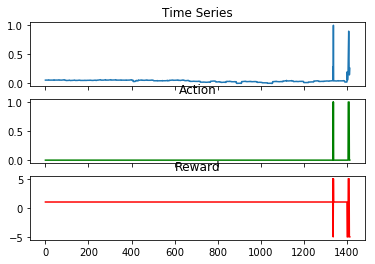

Episode 12/367


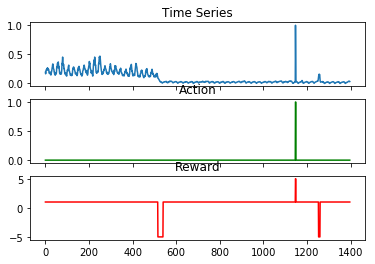

Episode 13/367


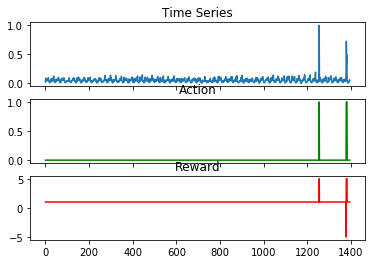

Episode 14/367


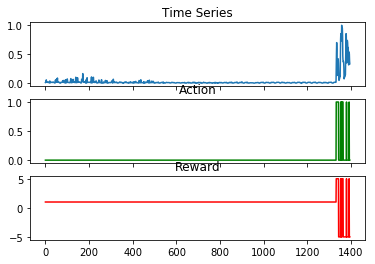

Episode 15/367


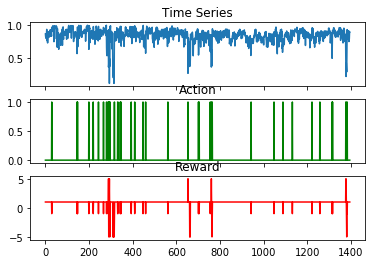

Episode 16/367


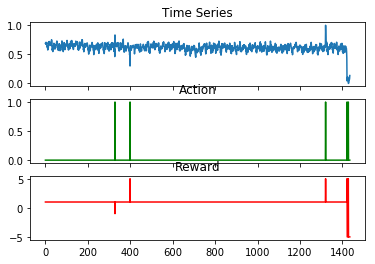

Episode 17/367


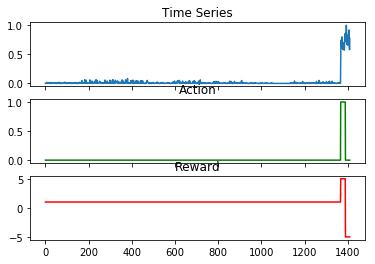

Episode 18/367


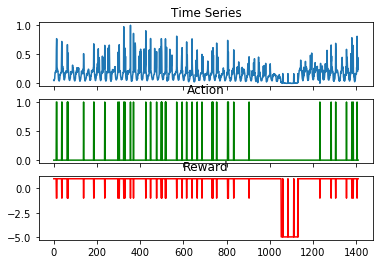

Episode 19/367


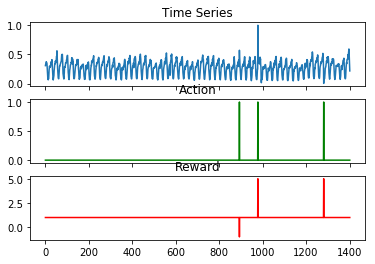

Episode 20/367


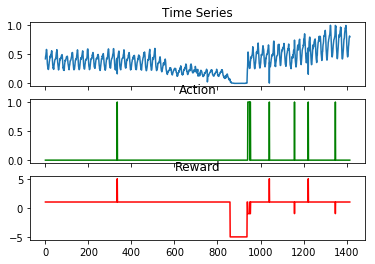

Episode 21/367


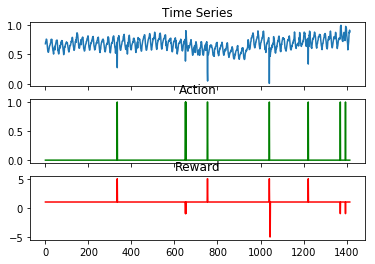

Episode 22/367


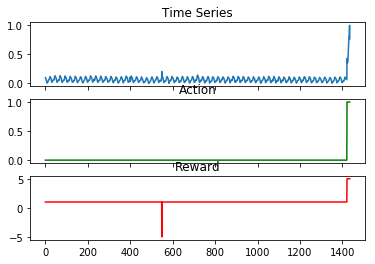

Episode 23/367


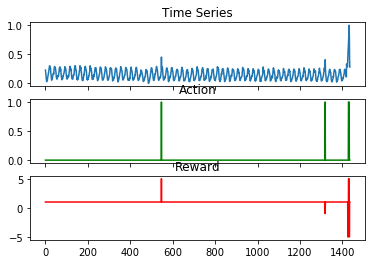

Episode 24/367


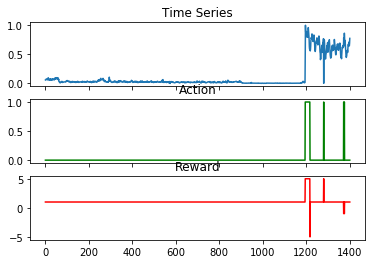

Episode 25/367


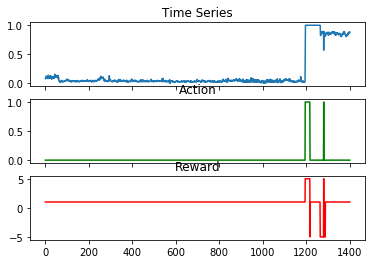

Episode 26/367


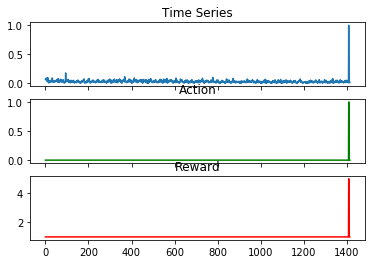

Episode 27/367


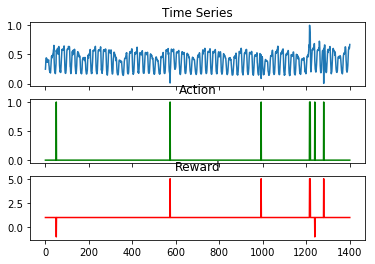

Episode 28/367


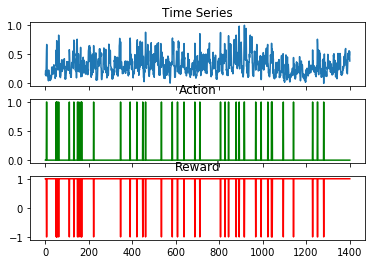

Episode 29/367


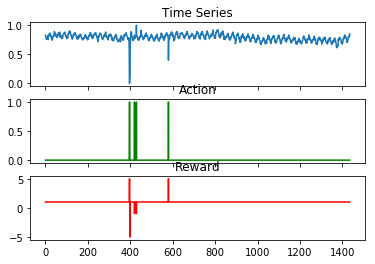

Episode 30/367


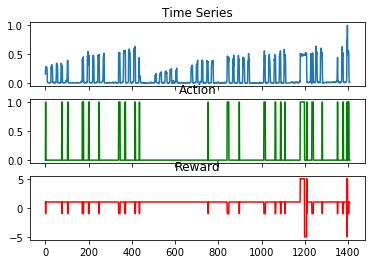

Episode 31/367


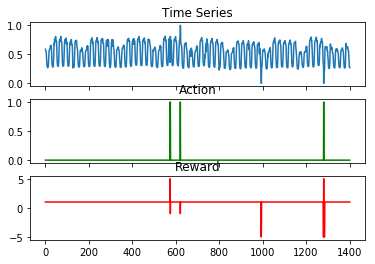

Episode 32/367


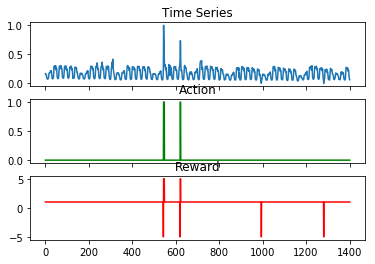

Episode 33/367


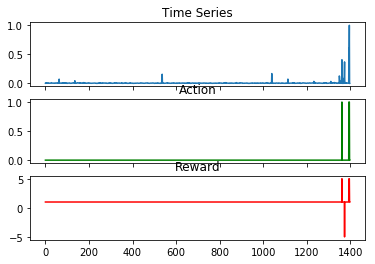

Episode 34/367


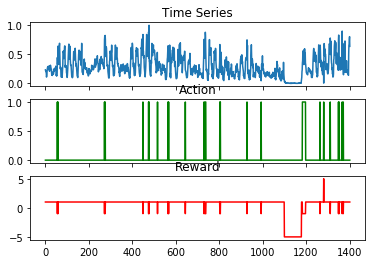

Episode 35/367


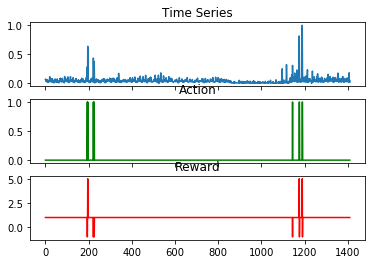

Episode 36/367


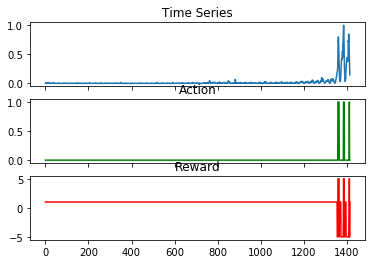

Episode 37/367


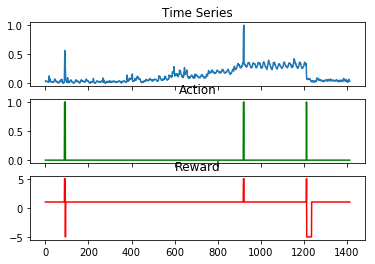

Episode 38/367


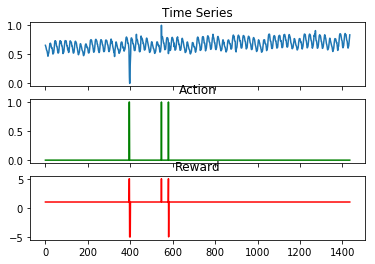

Episode 39/367


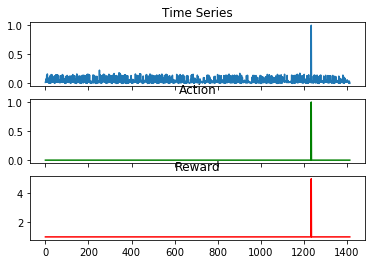

Episode 40/367


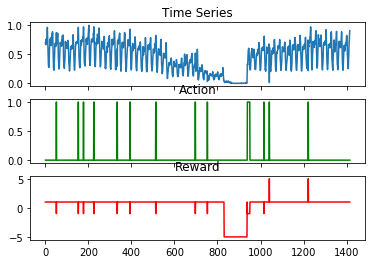

Episode 41/367


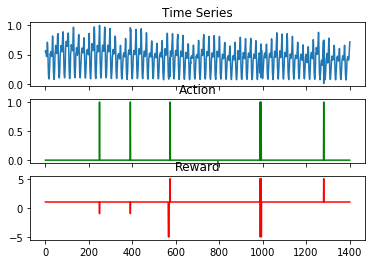

Episode 42/367


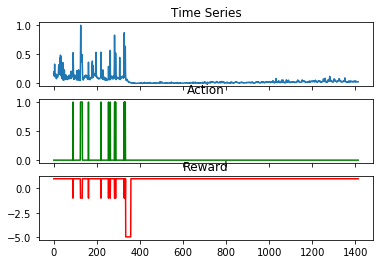

Episode 43/367


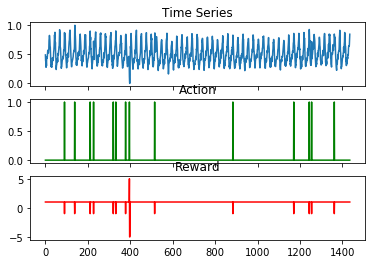

Episode 44/367


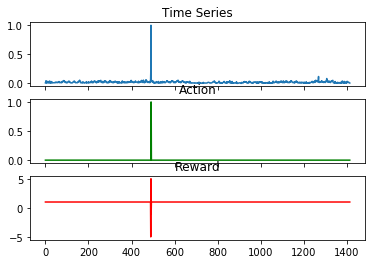

Episode 45/367


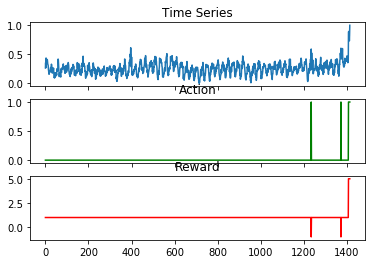

Episode 46/367


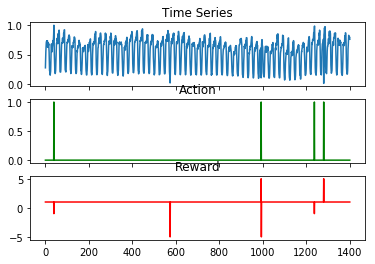

Episode 47/367


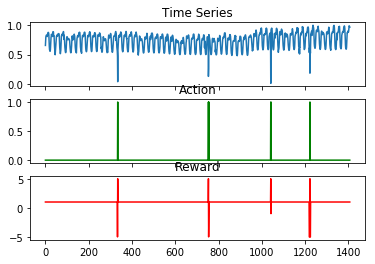

Episode 48/367


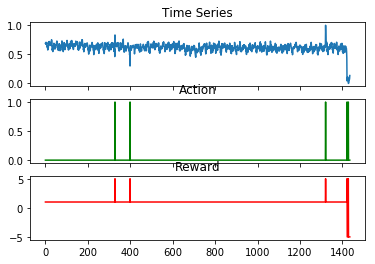

Episode 49/367


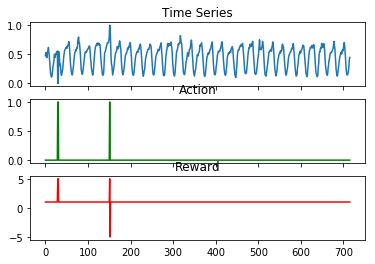

Episode 50/367


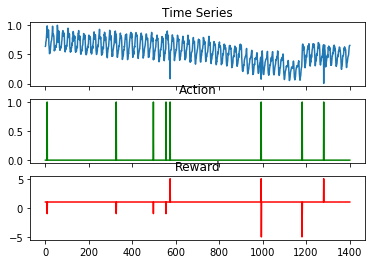

Episode 51/367


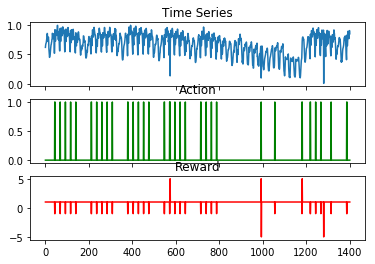

Episode 52/367


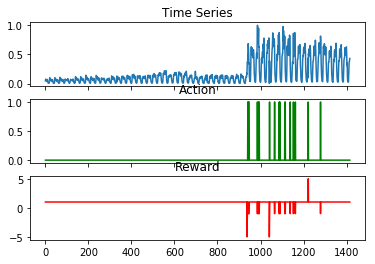

Episode 53/367


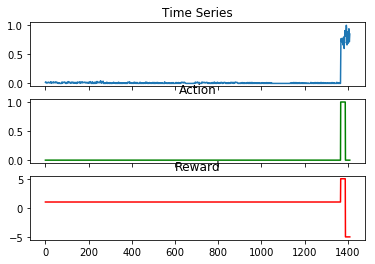

Episode 54/367


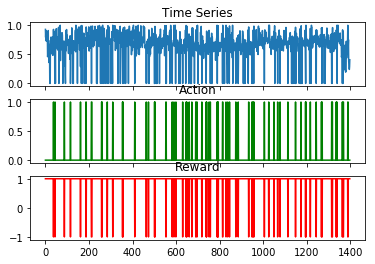

Episode 55/367


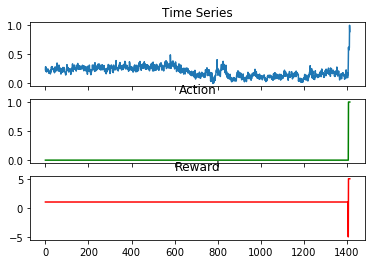

Episode 56/367


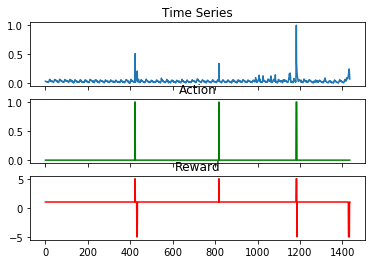

Episode 57/367


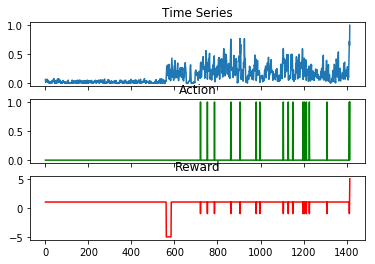

Episode 58/367


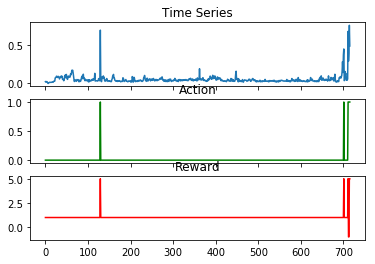

Episode 59/367


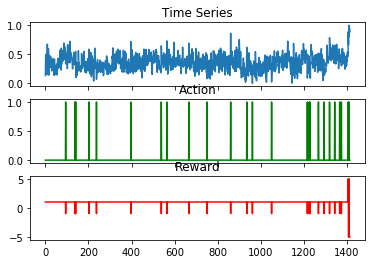

Episode 60/367


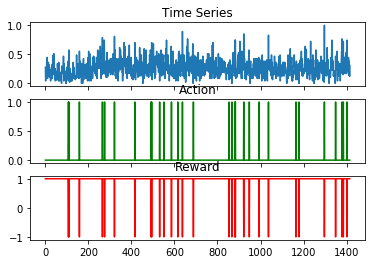

Episode 61/367


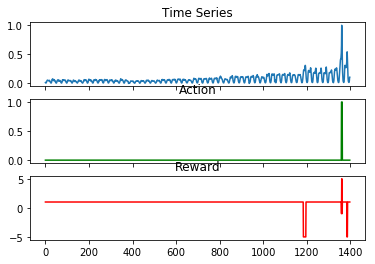

Episode 62/367


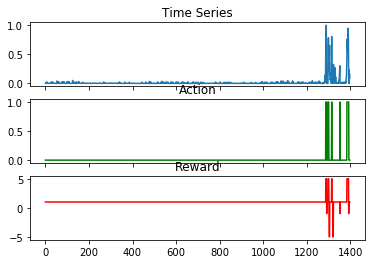

Episode 63/367


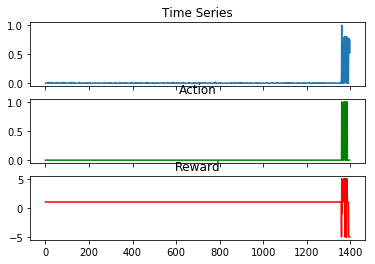

Episode 64/367


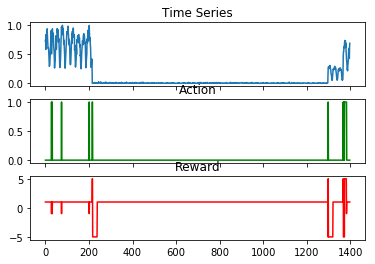

Episode 65/367


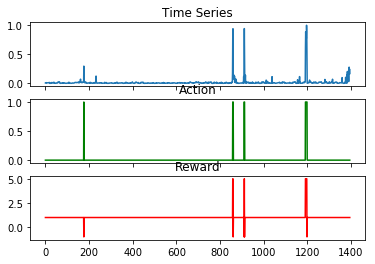

Episode 66/367


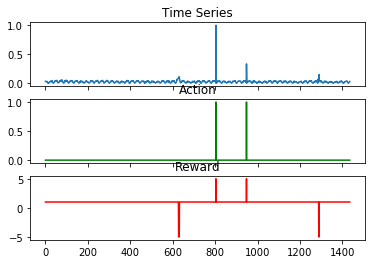

Episode 67/367


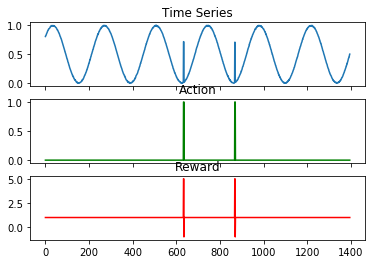

Episode 68/367


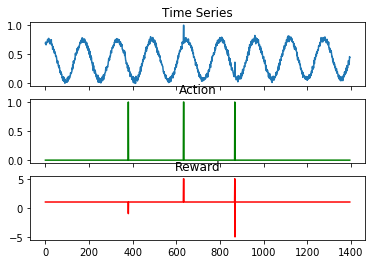

Episode 69/367


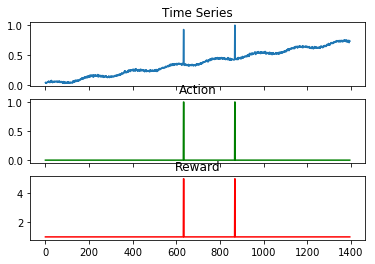

Episode 70/367


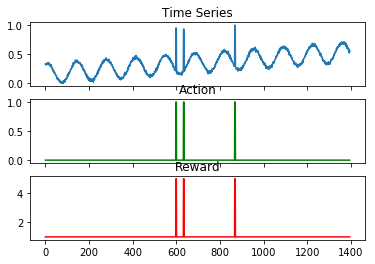

Episode 71/367


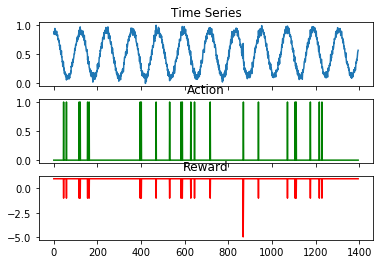

Episode 72/367


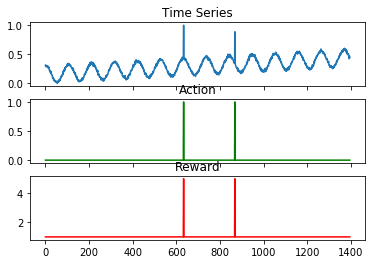

Episode 73/367


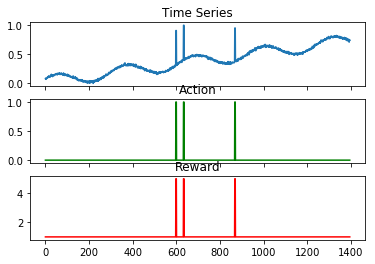

Episode 74/367


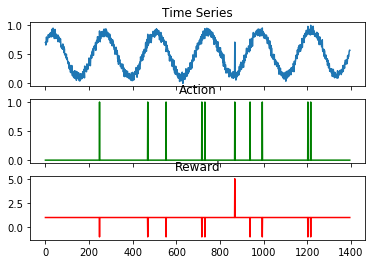

Episode 75/367


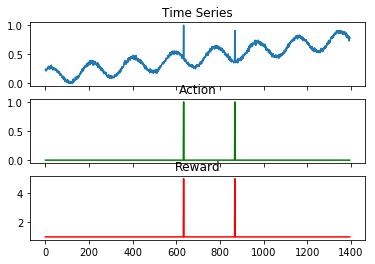

Episode 76/367


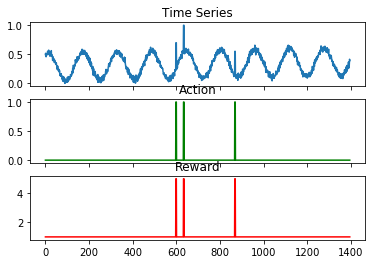

Episode 77/367


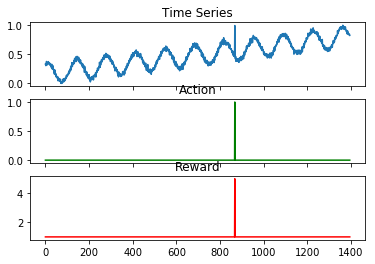

Episode 78/367


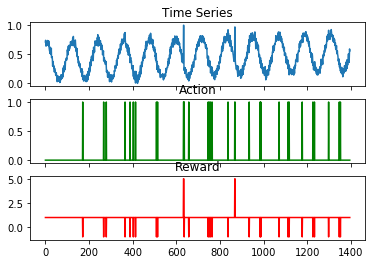

Episode 79/367


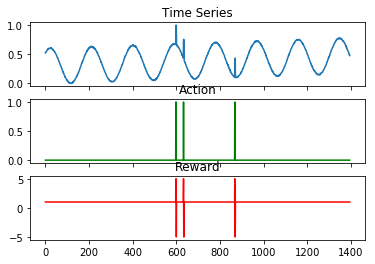

Episode 80/367


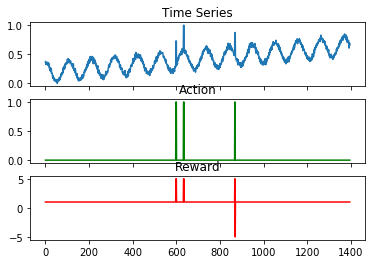

Episode 81/367


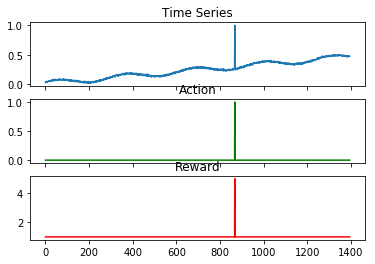

Episode 82/367


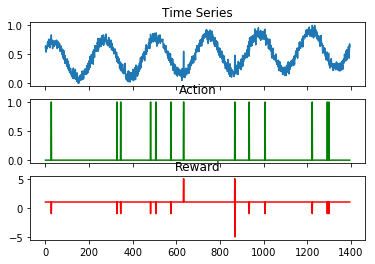

Episode 83/367


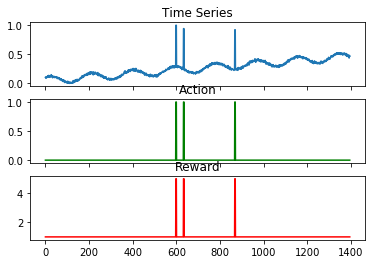

Episode 84/367


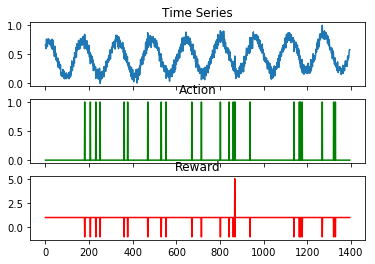

Episode 85/367


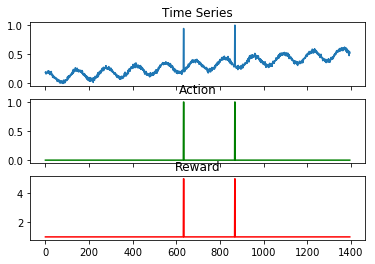

Episode 86/367


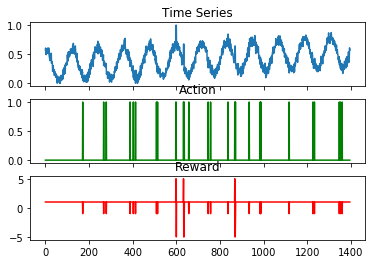

Episode 87/367


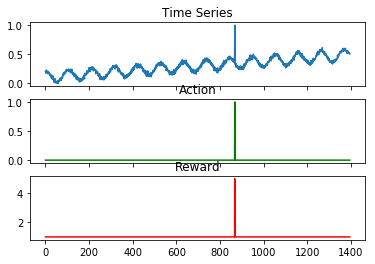

Episode 88/367


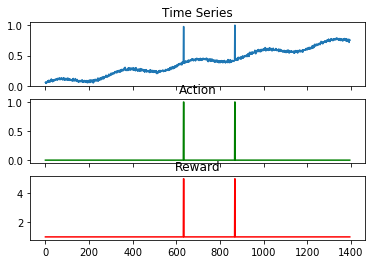

Episode 89/367


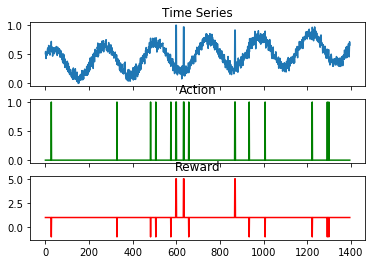

Episode 90/367


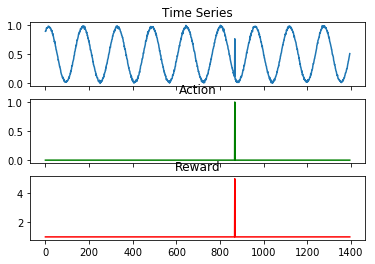

Episode 91/367


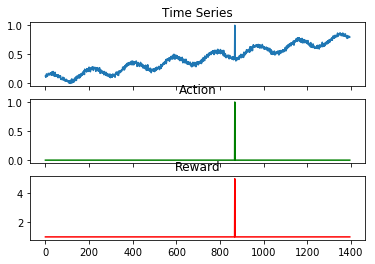

Episode 92/367


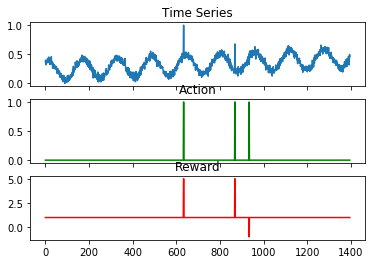

Episode 93/367


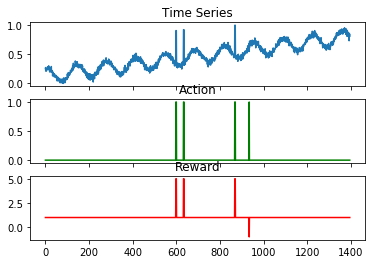

Episode 94/367


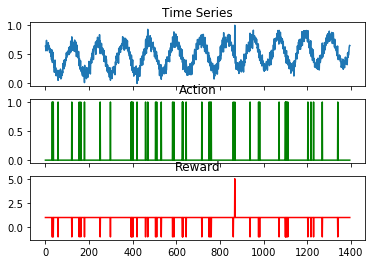

Episode 95/367


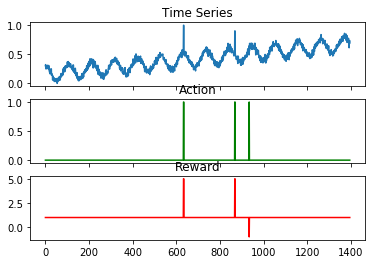

Episode 96/367


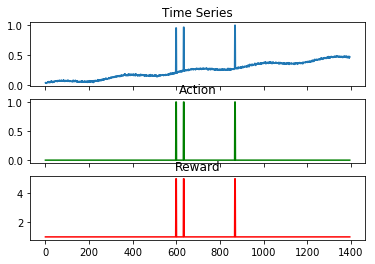

Episode 97/367


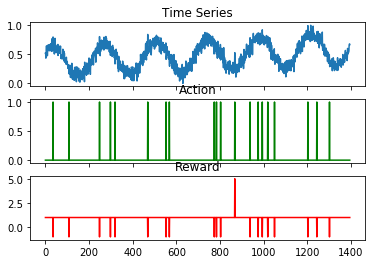

Episode 98/367


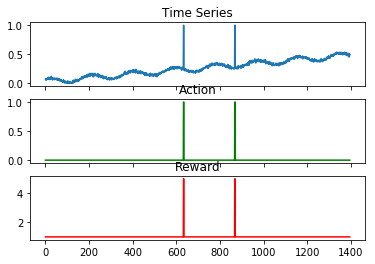

Episode 99/367


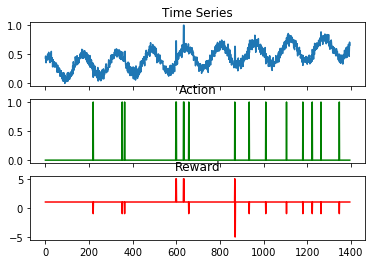

Episode 100/367


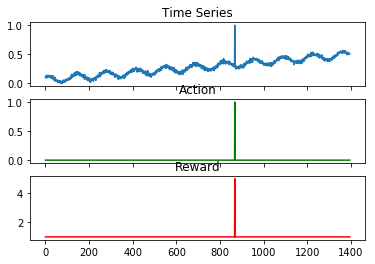

Episode 101/367


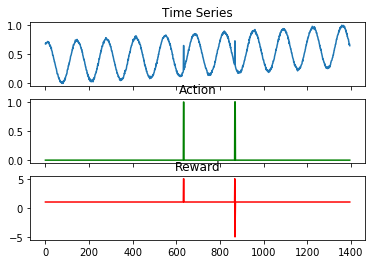

Episode 102/367


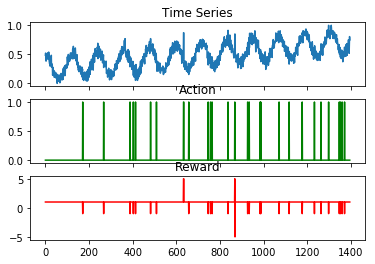

Episode 103/367


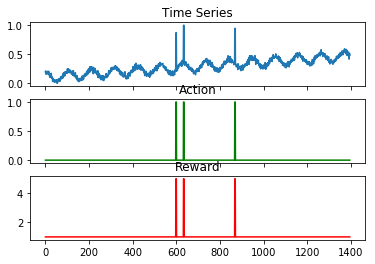

Episode 104/367


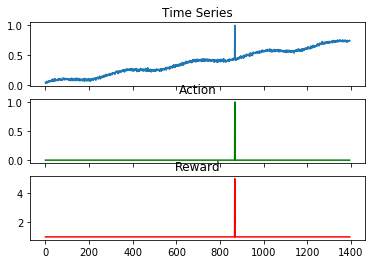

Episode 105/367


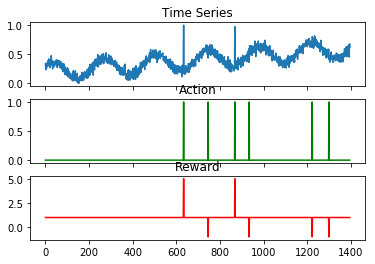

Episode 106/367


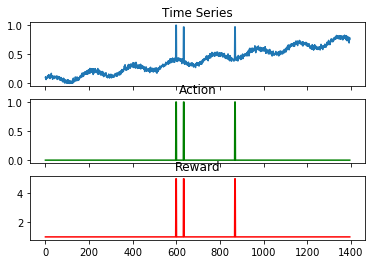

Episode 107/367


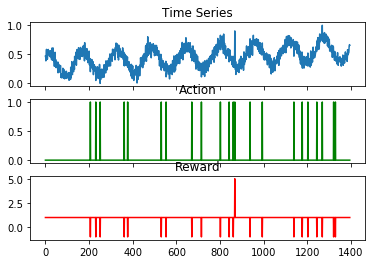

Episode 108/367


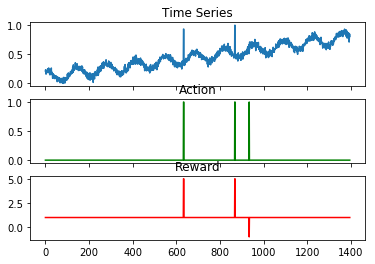

Episode 109/367


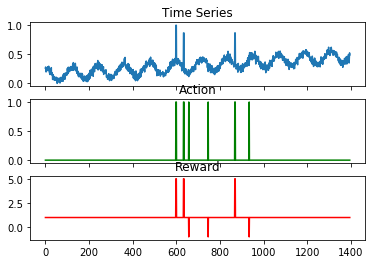

Episode 110/367


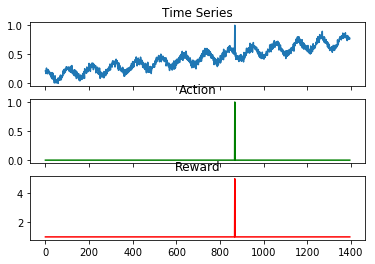

Episode 111/367


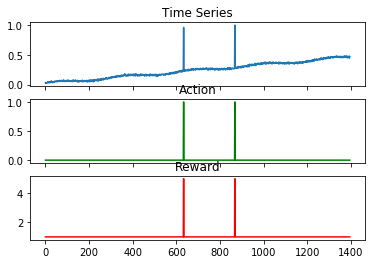

Episode 112/367


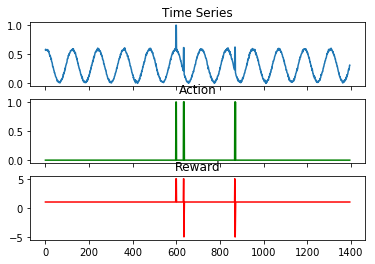

Episode 113/367


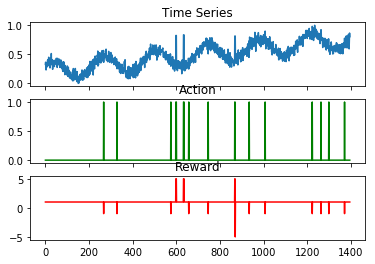

Episode 114/367


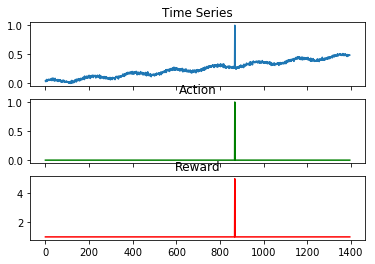

Episode 115/367


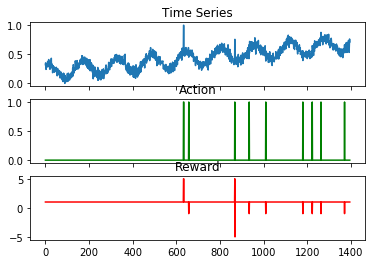

Episode 116/367


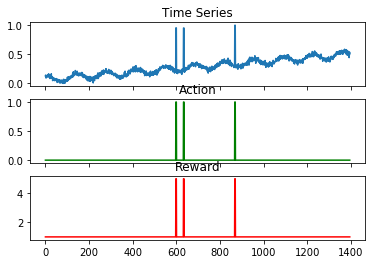

Episode 117/367


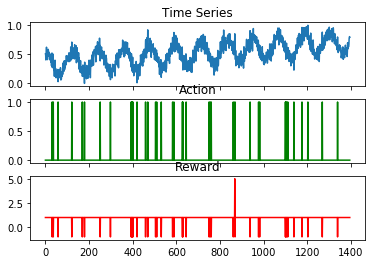

Episode 118/367


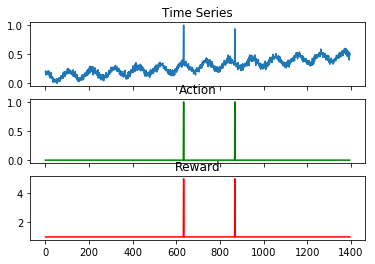

Episode 119/367


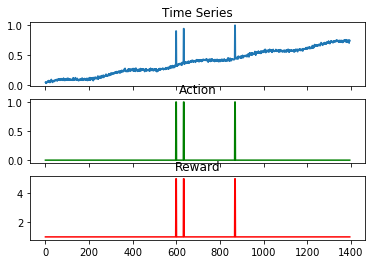

Episode 120/367


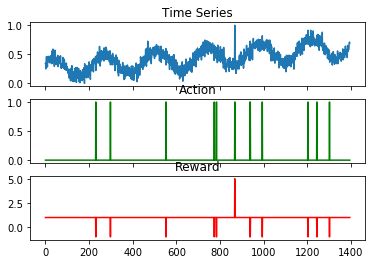

Episode 121/367


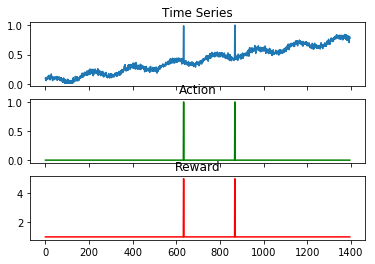

Episode 122/367


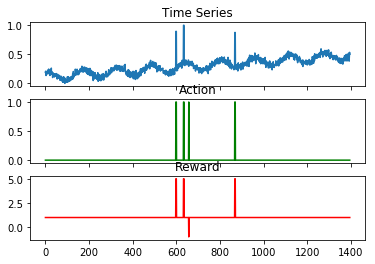

Episode 123/367


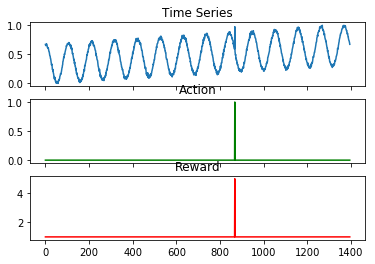

Episode 124/367


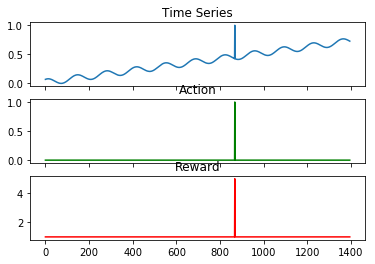

Episode 125/367


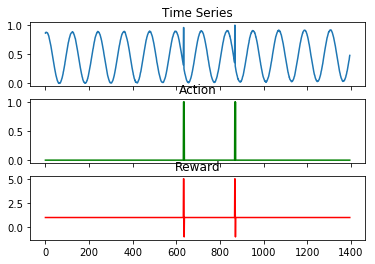

Episode 126/367


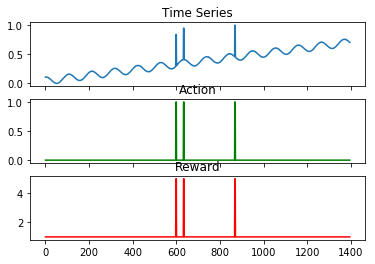

Episode 127/367


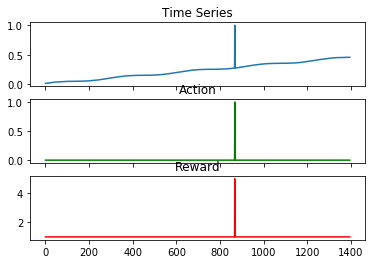

Episode 128/367


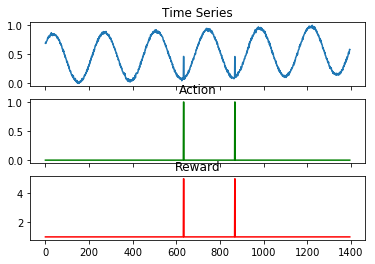

Episode 129/367


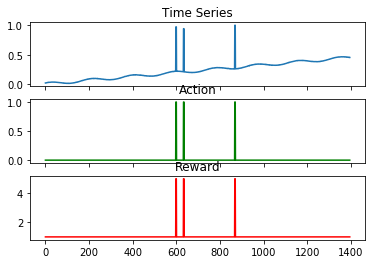

Episode 130/367


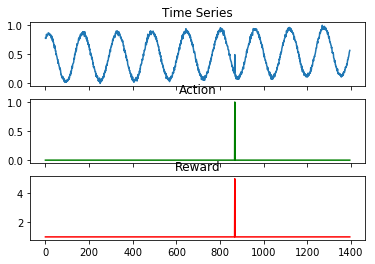

Episode 131/367


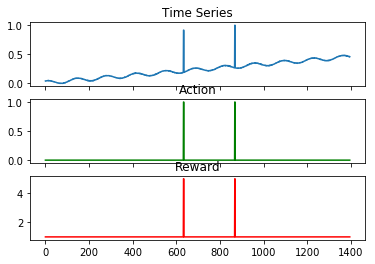

Episode 132/367


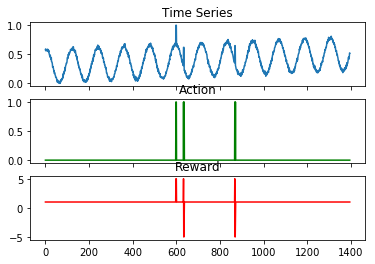

Episode 133/367


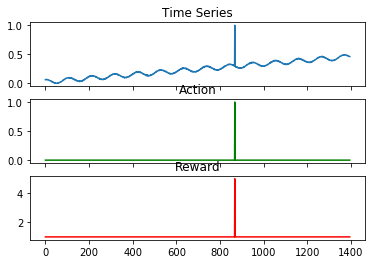

Episode 134/367


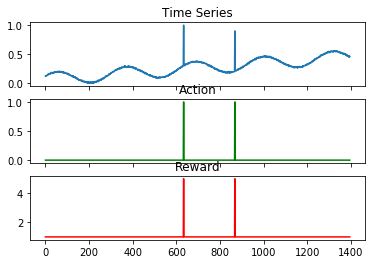

Episode 135/367


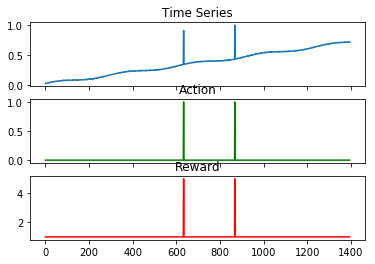

Episode 136/367


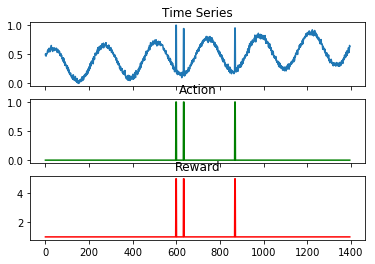

Episode 137/367


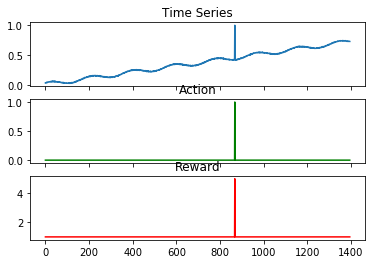

Episode 138/367


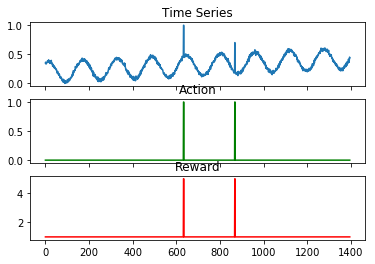

Episode 139/367


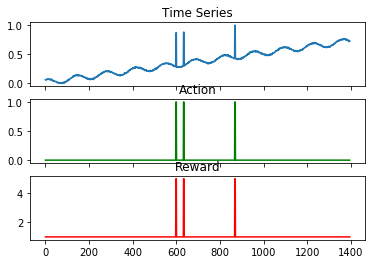

Episode 140/367


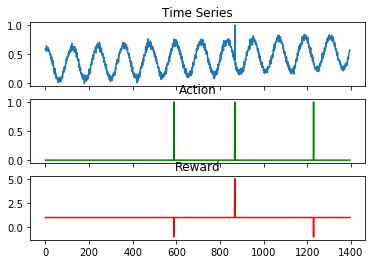

Episode 141/367


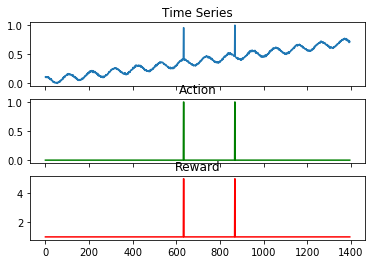

Episode 142/367


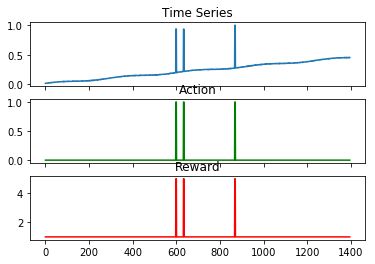

Episode 143/367


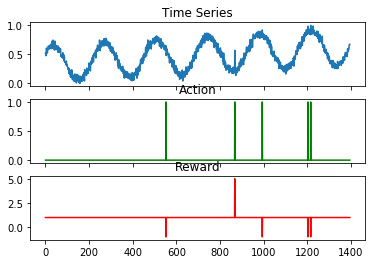

Episode 144/367


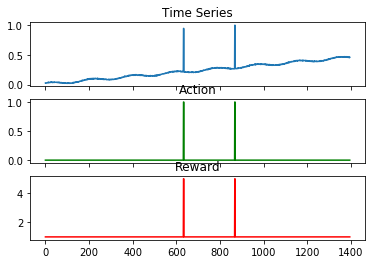

Episode 145/367


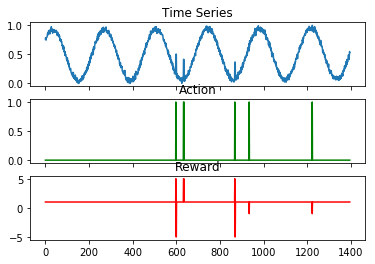

Episode 146/367


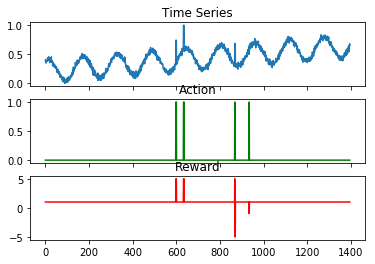

Episode 147/367


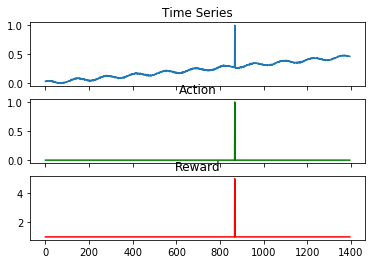

Episode 148/367


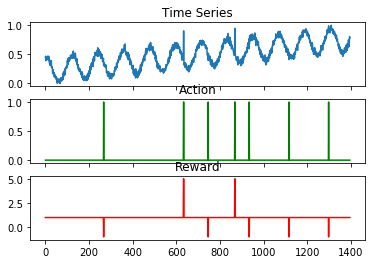

Episode 149/367


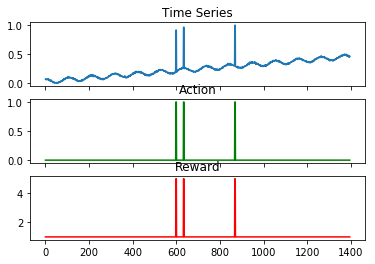

Episode 150/367


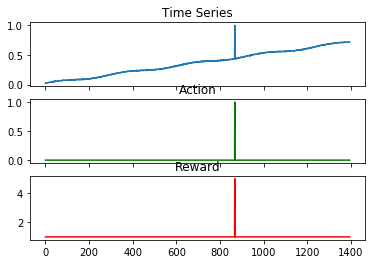

Episode 151/367


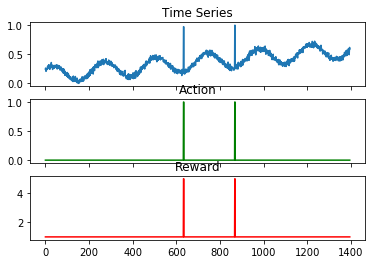

Episode 152/367


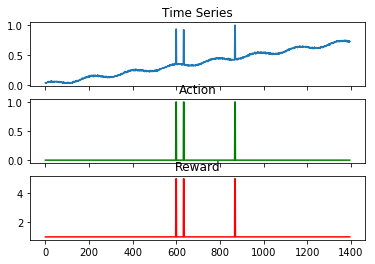

Episode 153/367


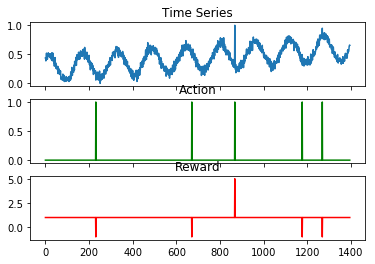

Episode 154/367


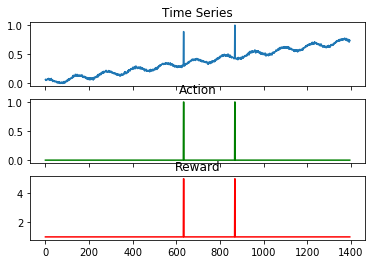

Episode 155/367


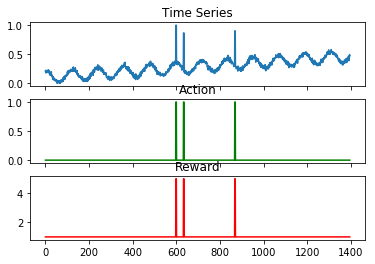

Episode 156/367


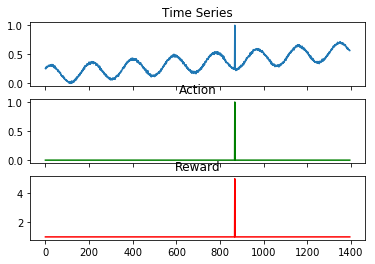

Episode 157/367


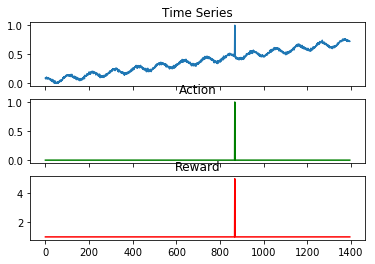

Episode 158/367


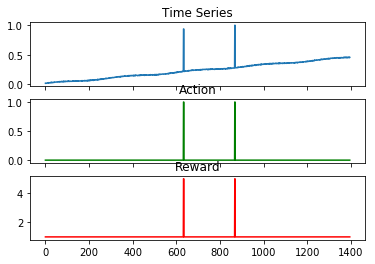

Episode 159/367


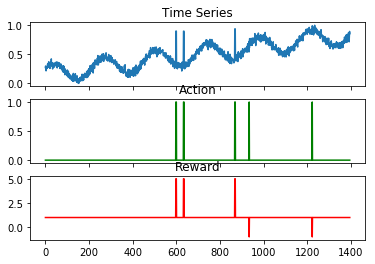

Episode 160/367


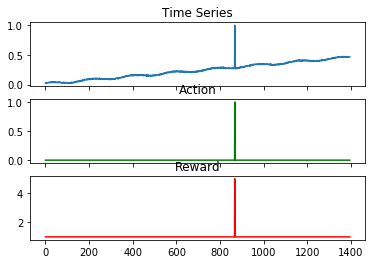

Episode 161/367


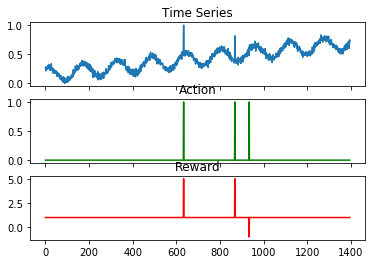

Episode 162/367


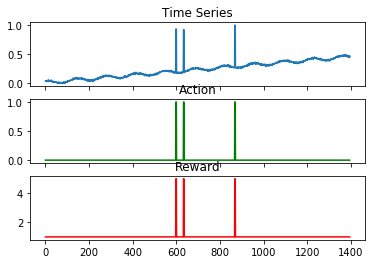

Episode 163/367


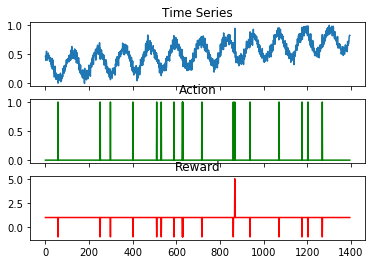

Episode 164/367


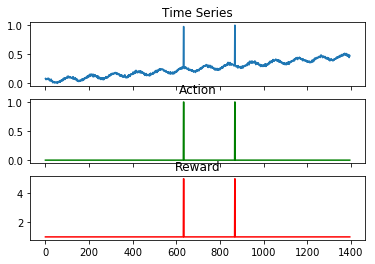

Episode 165/367


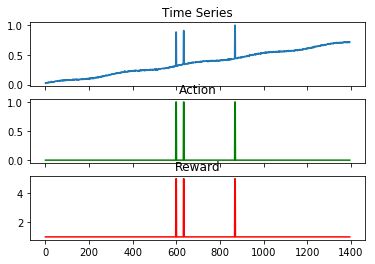

Episode 166/367


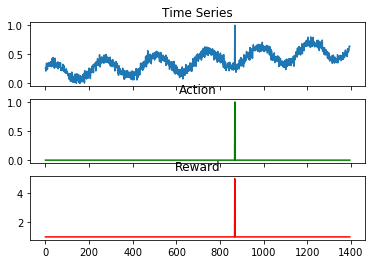

Episode 167/367


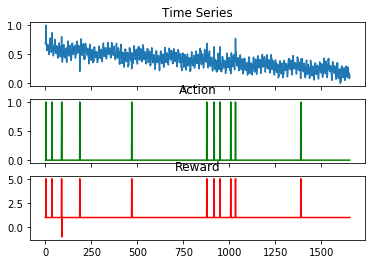

Episode 168/367


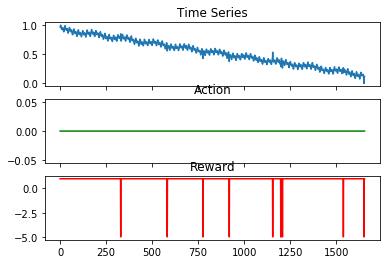

Episode 169/367


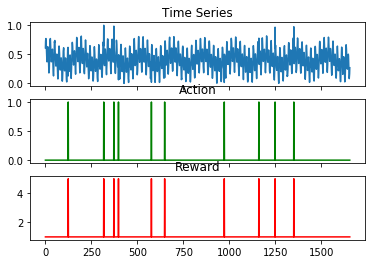

Episode 170/367


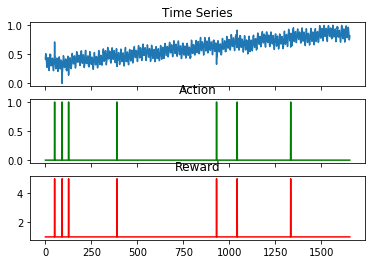

Episode 171/367


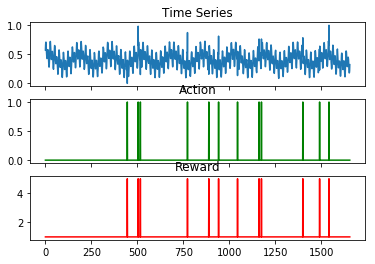

Episode 172/367


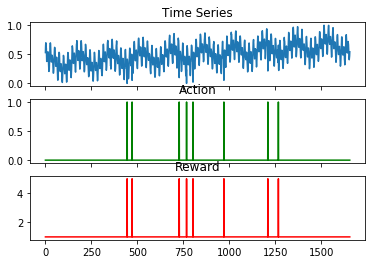

Episode 173/367


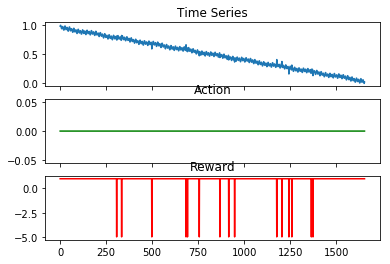

Episode 174/367


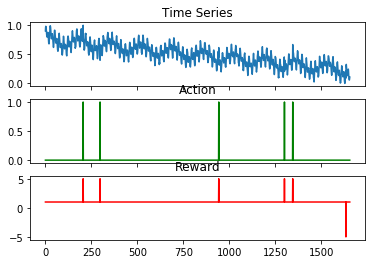

Episode 175/367


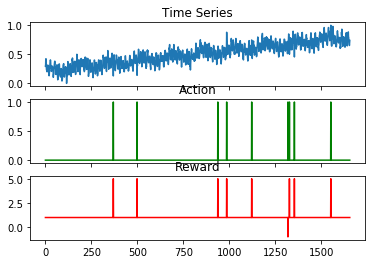

Episode 176/367


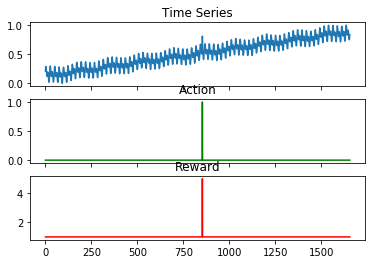

Episode 177/367


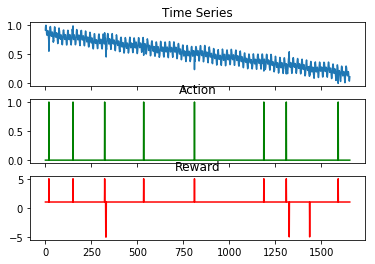

Episode 178/367


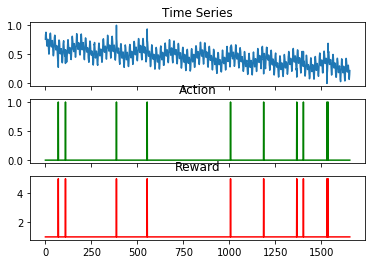

Episode 179/367


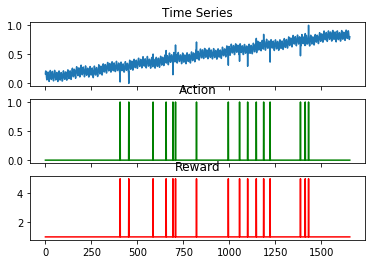

Episode 180/367


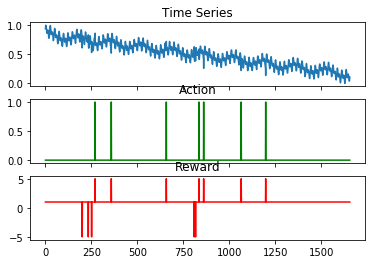

Episode 181/367


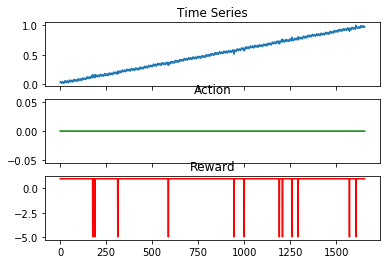

Episode 182/367


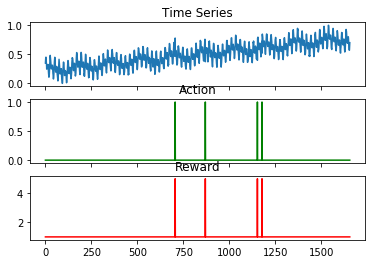

Episode 183/367


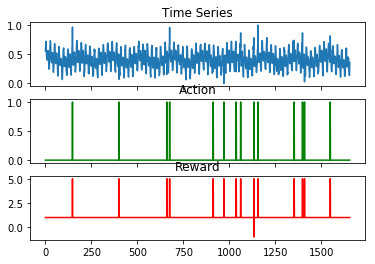

Episode 184/367


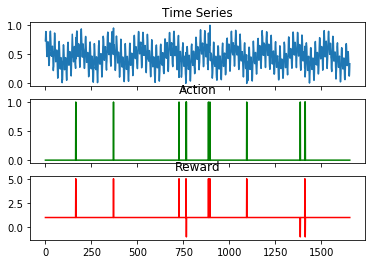

Episode 185/367


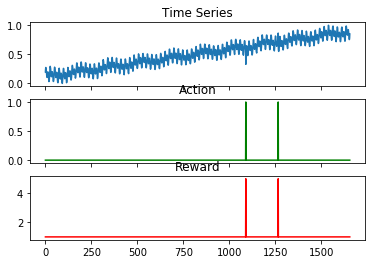

Episode 186/367


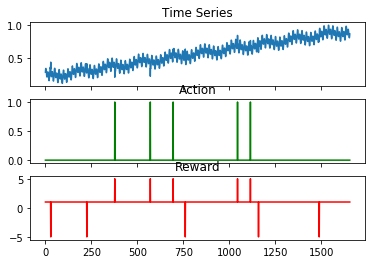

Episode 187/367


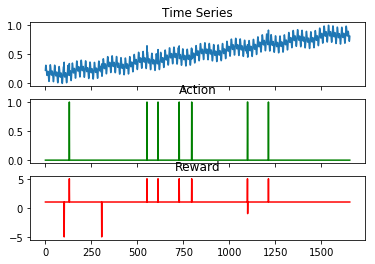

Episode 188/367


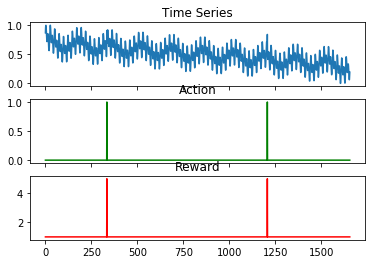

Episode 189/367


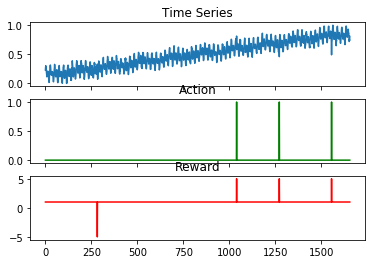

Episode 190/367


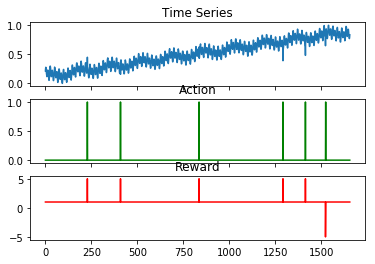

Episode 191/367


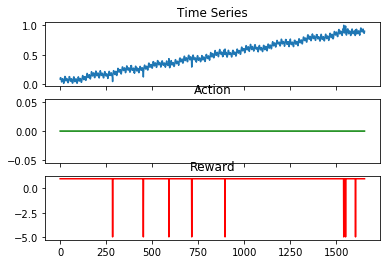

Episode 192/367


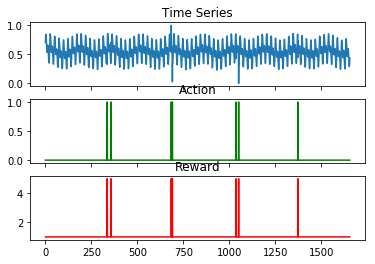

Episode 193/367


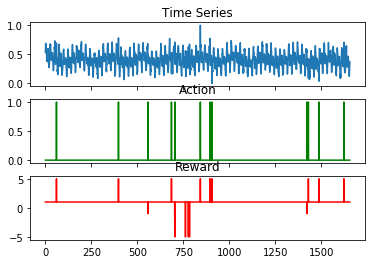

Episode 194/367


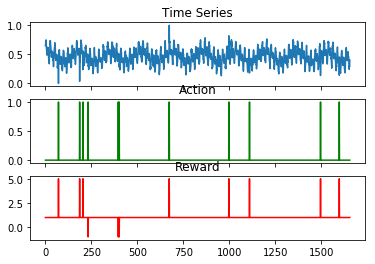

Episode 195/367


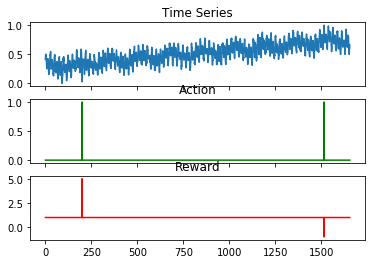

Episode 196/367


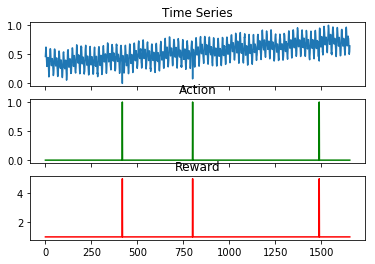

Episode 197/367


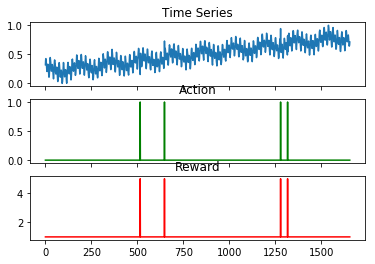

Episode 198/367


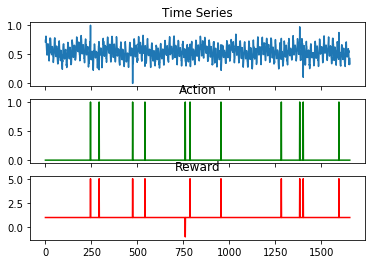

Episode 199/367


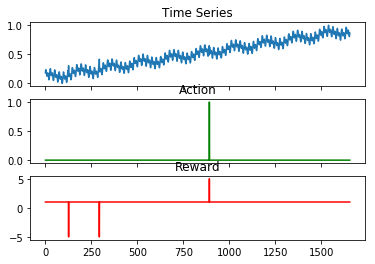

Episode 200/367


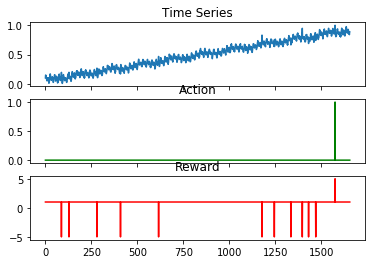

Episode 201/367


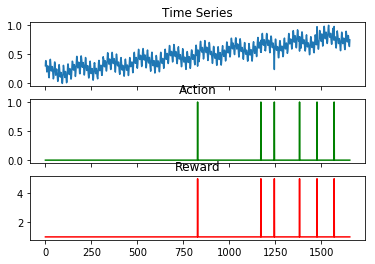

Episode 202/367


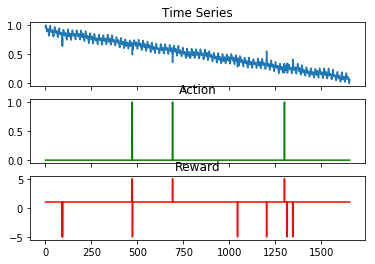

Episode 203/367


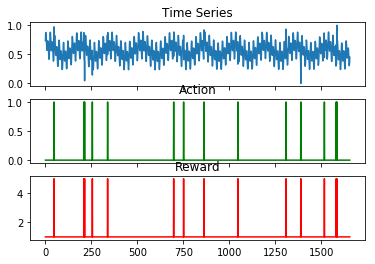

Episode 204/367


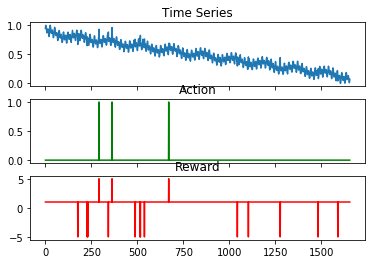

Episode 205/367


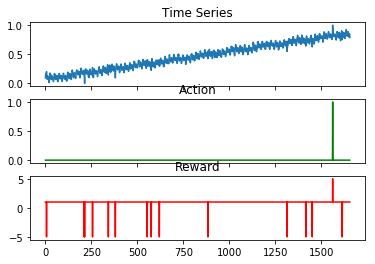

Episode 206/367


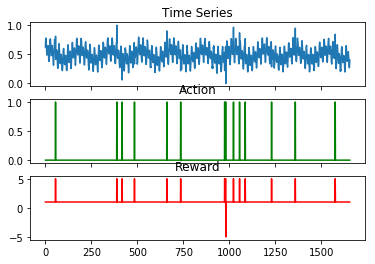

Episode 207/367


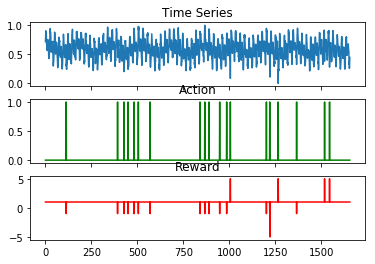

Episode 208/367


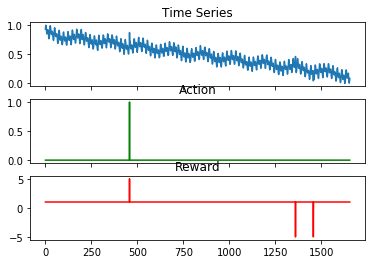

Episode 209/367


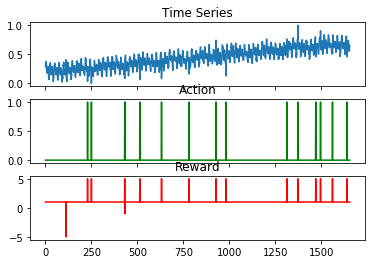

Episode 210/367


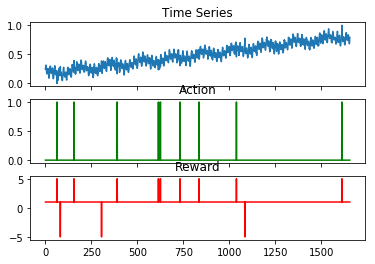

Episode 211/367


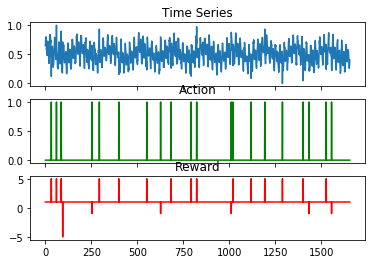

Episode 212/367


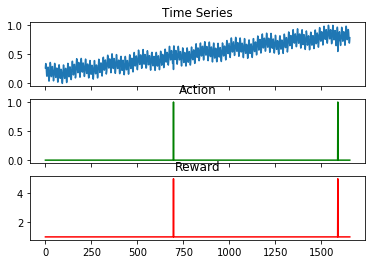

Episode 213/367


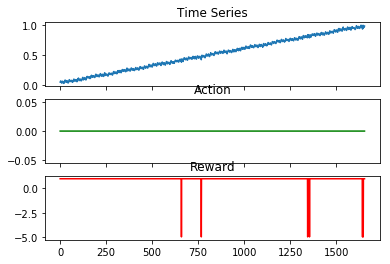

Episode 214/367


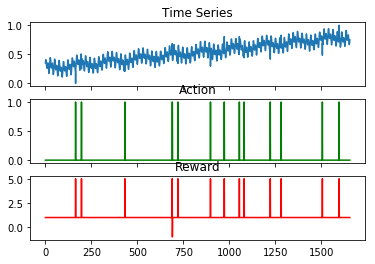

Episode 215/367


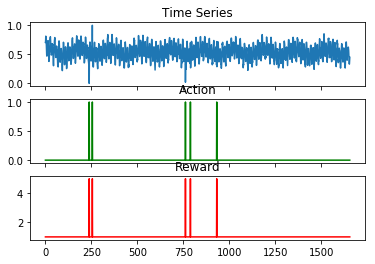

Episode 216/367


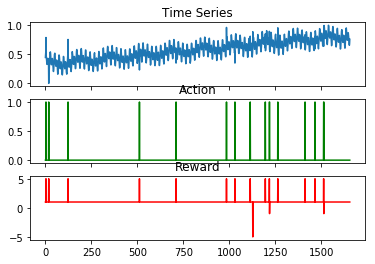

Episode 217/367


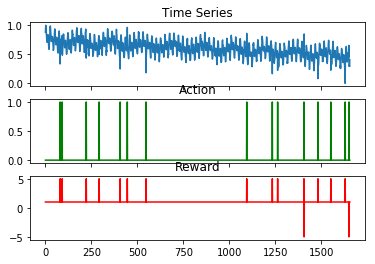

Episode 218/367


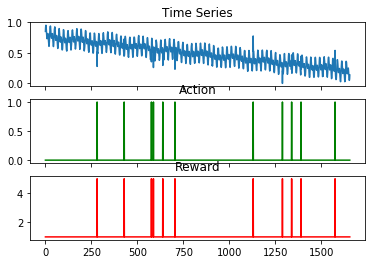

Episode 219/367


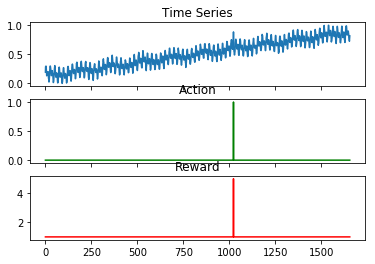

Episode 220/367


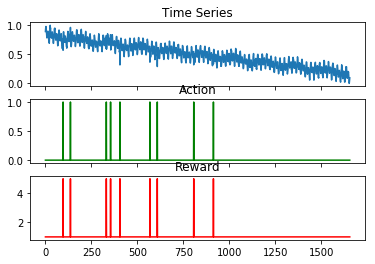

Episode 221/367


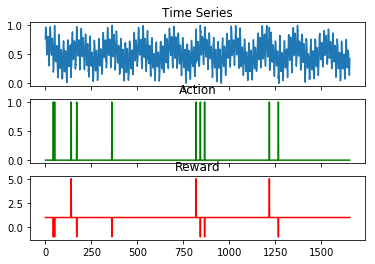

Episode 222/367


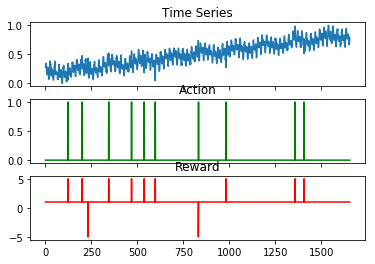

Episode 223/367


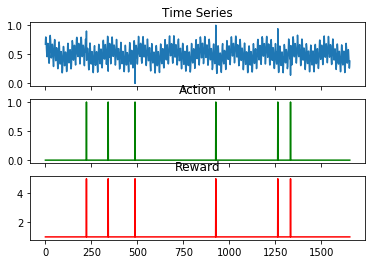

Episode 224/367


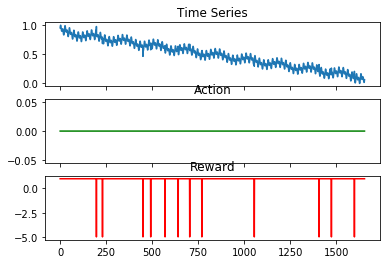

Episode 225/367


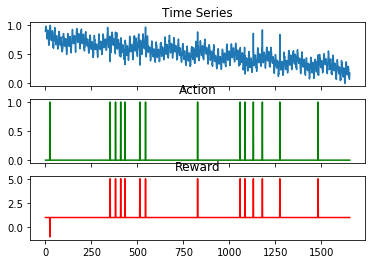

Episode 226/367


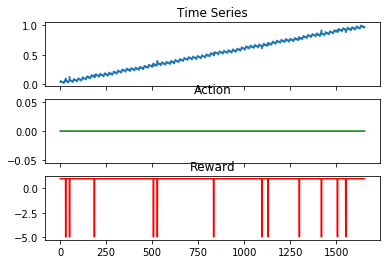

Episode 227/367


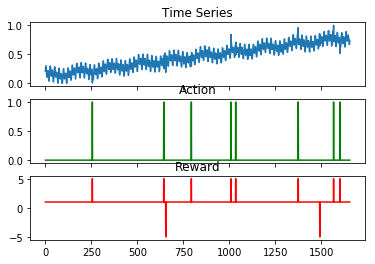

Episode 228/367


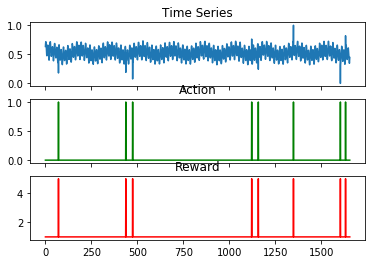

Episode 229/367


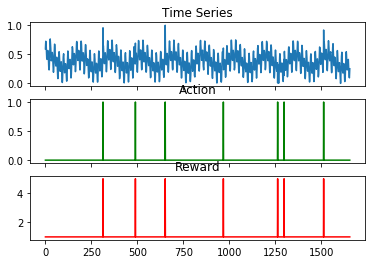

Episode 230/367


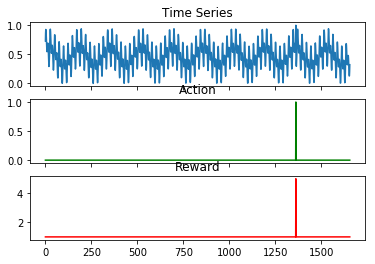

Episode 231/367


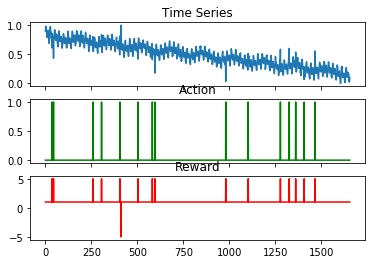

Episode 232/367


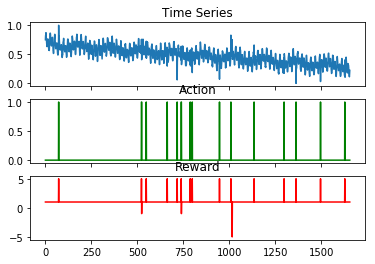

Episode 233/367


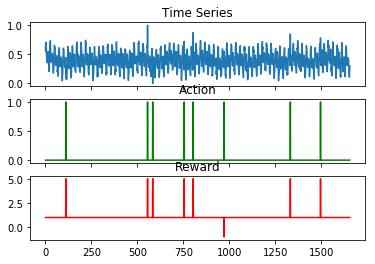

Episode 234/367


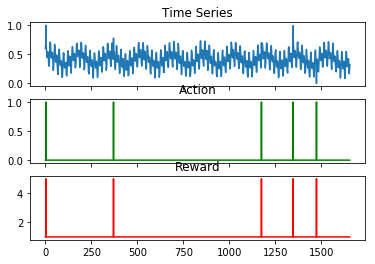

Episode 235/367


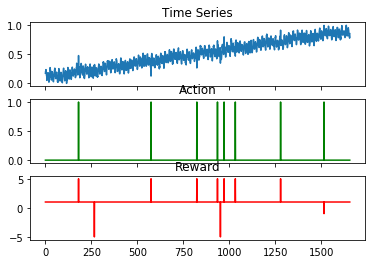

Episode 236/367


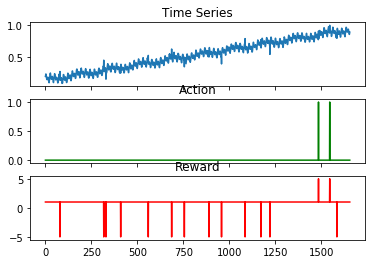

Episode 237/367


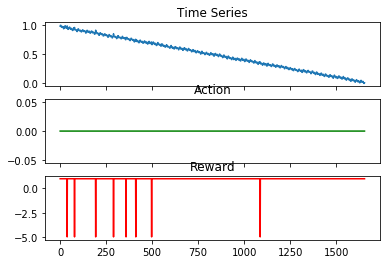

Episode 238/367


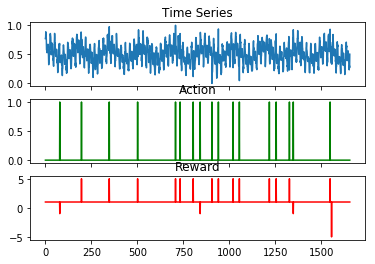

Episode 239/367


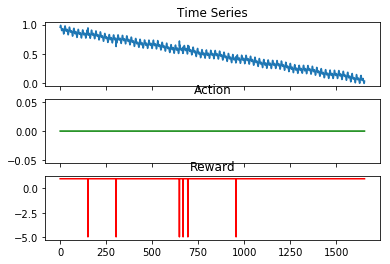

Episode 240/367


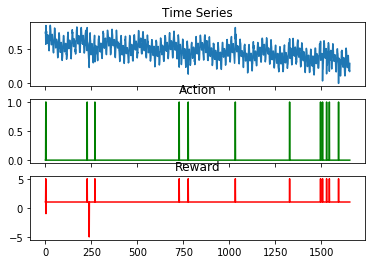

Episode 241/367


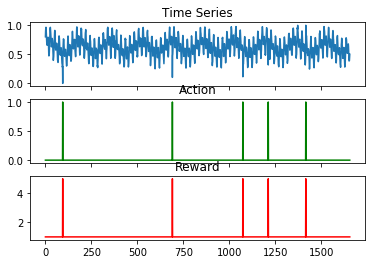

Episode 242/367


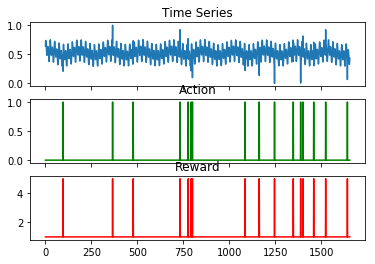

Episode 243/367


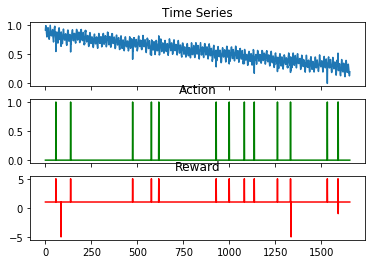

Episode 244/367


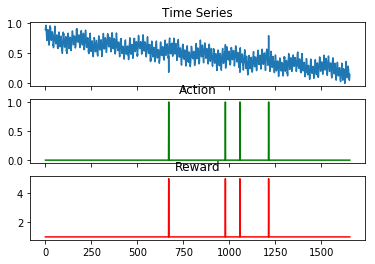

Episode 245/367


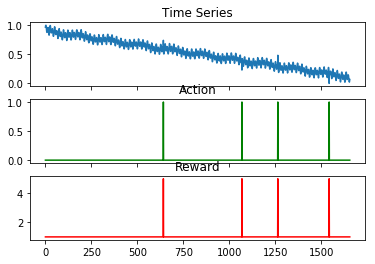

Episode 246/367


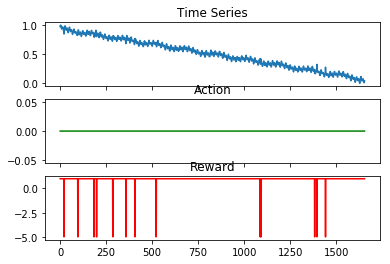

Episode 247/367


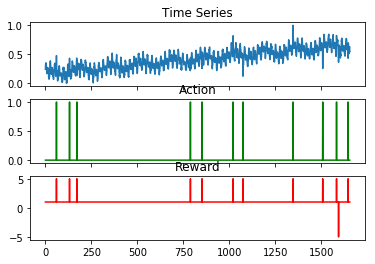

Episode 248/367


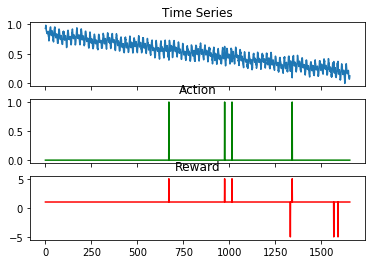

Episode 249/367


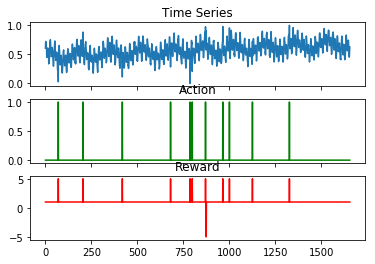

Episode 250/367


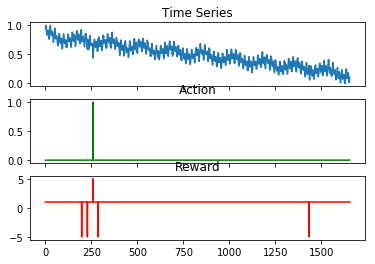

Episode 251/367


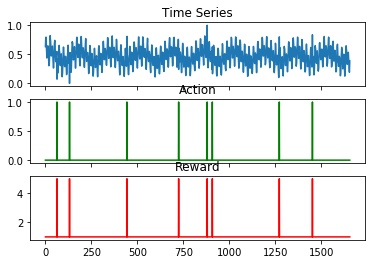

Episode 252/367


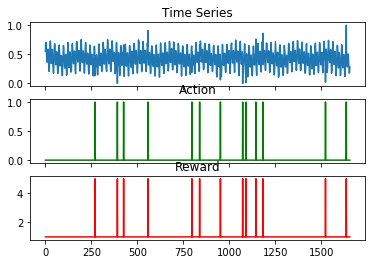

Episode 253/367


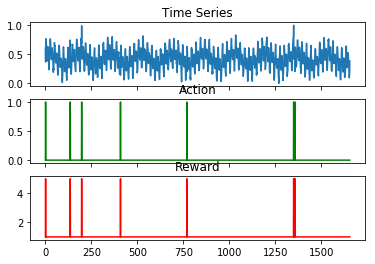

Episode 254/367


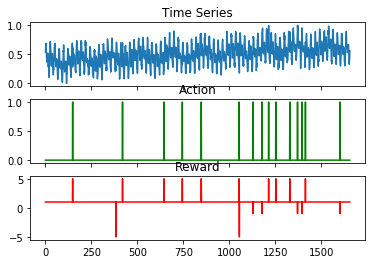

Episode 255/367


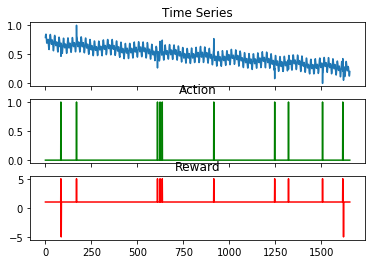

Episode 256/367


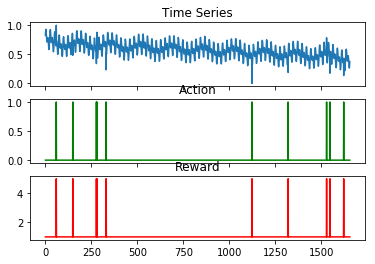

Episode 257/367


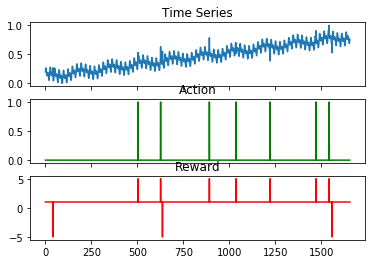

Episode 258/367


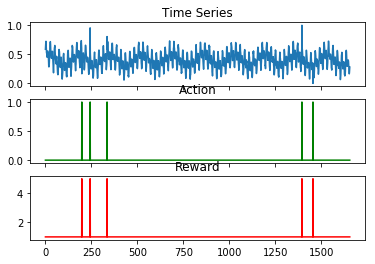

Episode 259/367


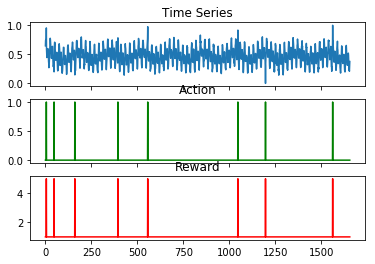

Episode 260/367


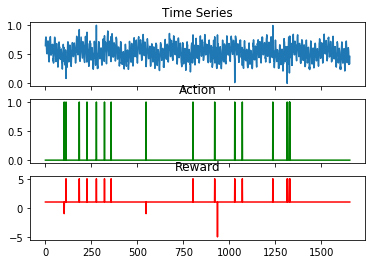

Episode 261/367


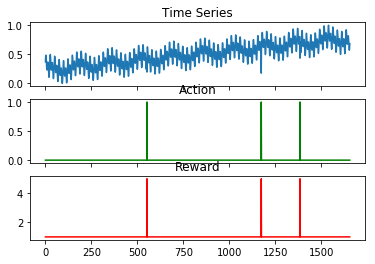

Episode 262/367


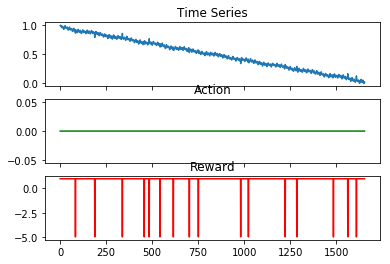

Episode 263/367


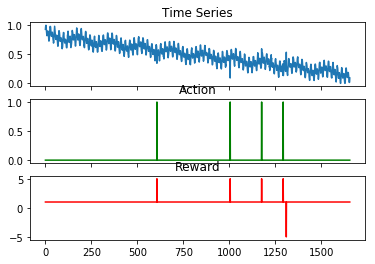

Episode 264/367


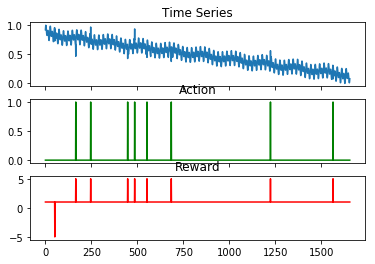

Episode 265/367


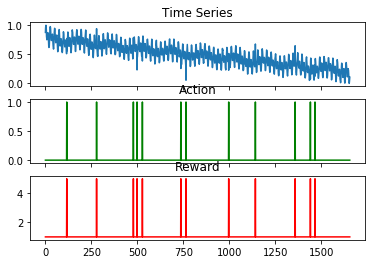

Episode 266/367


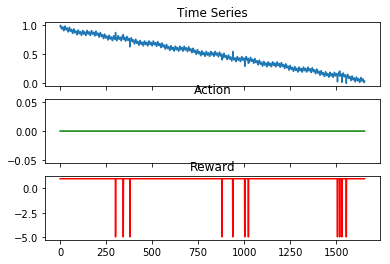

Episode 267/367


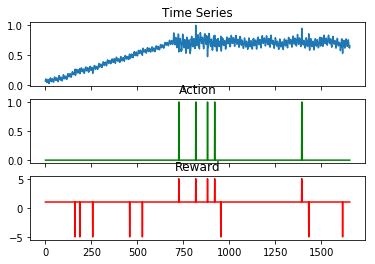

Episode 268/367


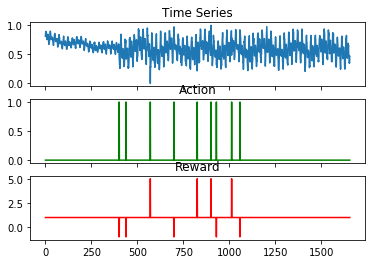

Episode 269/367


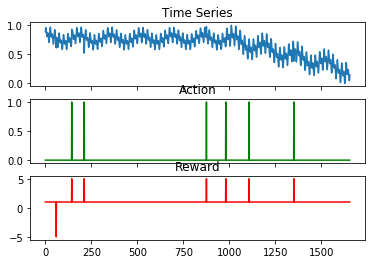

Episode 270/367


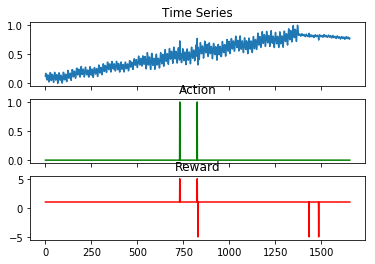

Episode 271/367


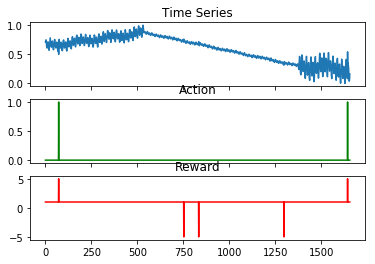

Episode 272/367


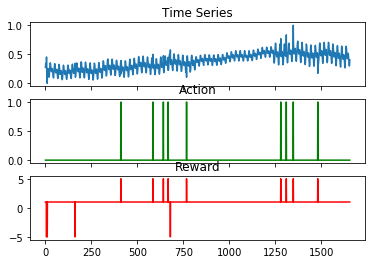

Episode 273/367


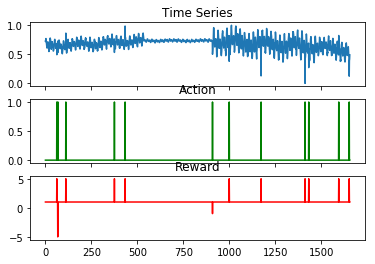

Episode 274/367


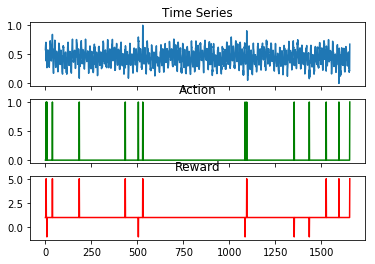

Episode 275/367


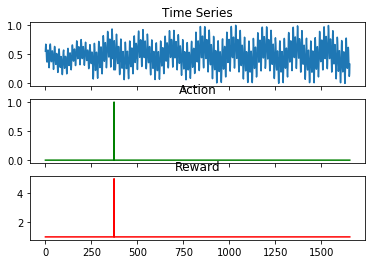

Episode 276/367


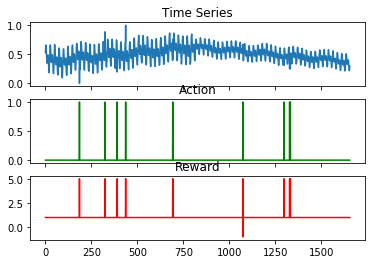

Episode 277/367


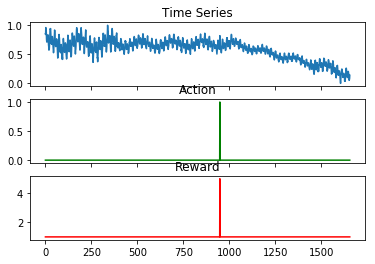

Episode 278/367


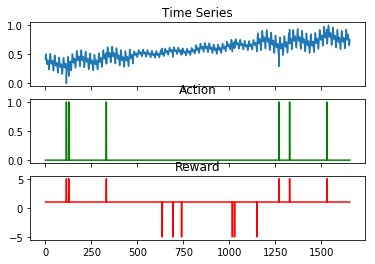

Episode 279/367


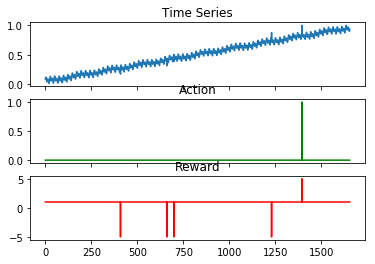

Episode 280/367


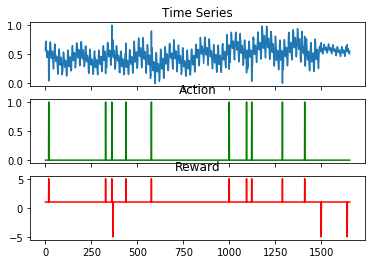

Episode 281/367


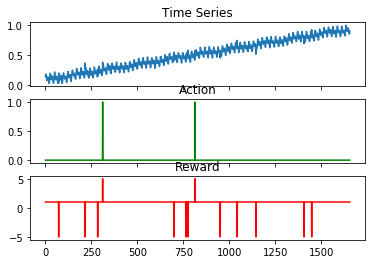

Episode 282/367


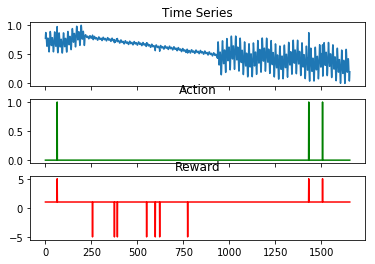

Episode 283/367


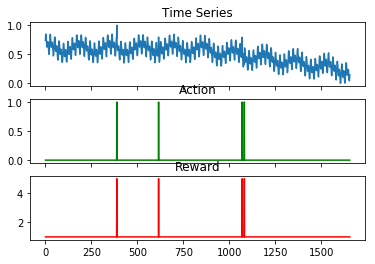

Episode 284/367


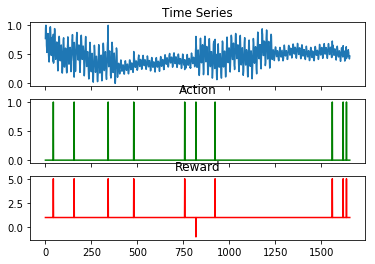

Episode 285/367


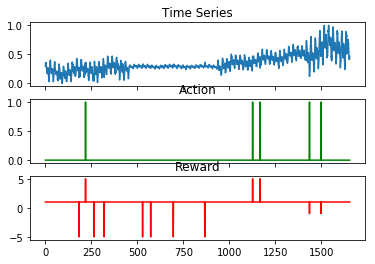

Episode 286/367


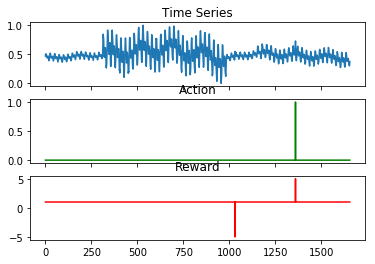

Episode 287/367


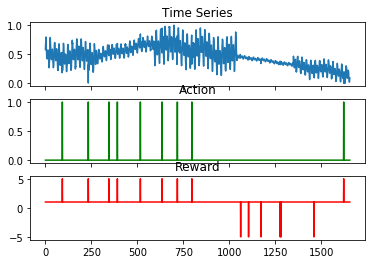

Episode 288/367


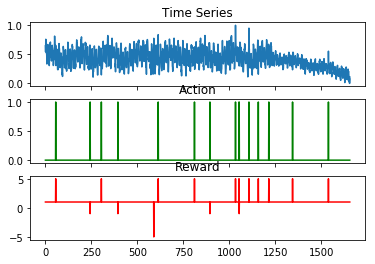

Episode 289/367


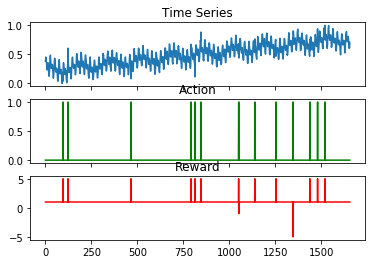

Episode 290/367


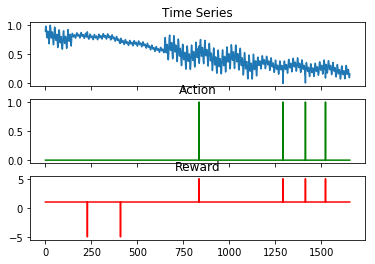

Episode 291/367


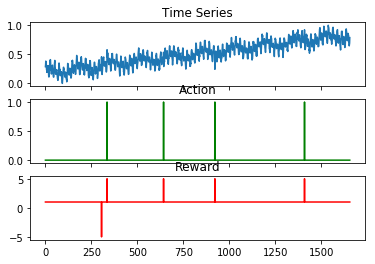

Episode 292/367


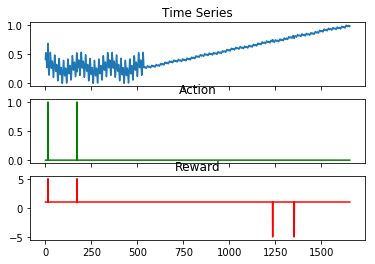

Episode 293/367


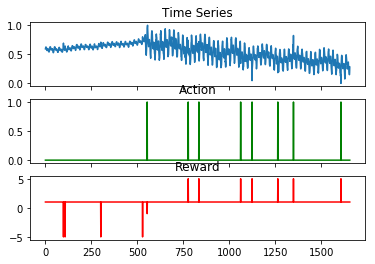

Episode 294/367


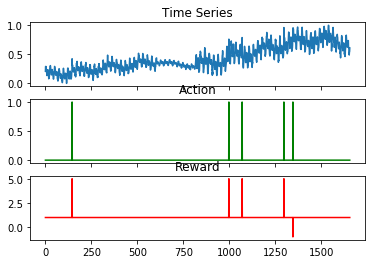

Episode 295/367


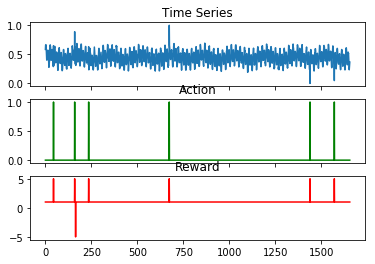

Episode 296/367


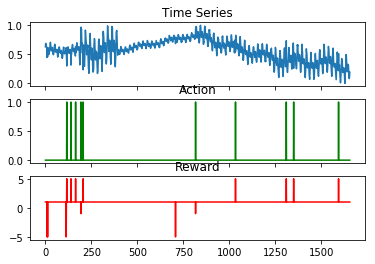

Episode 297/367


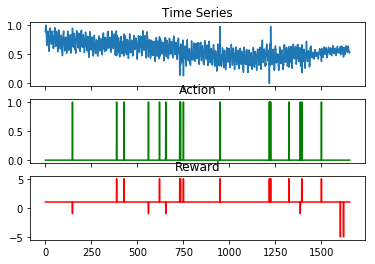

Episode 298/367


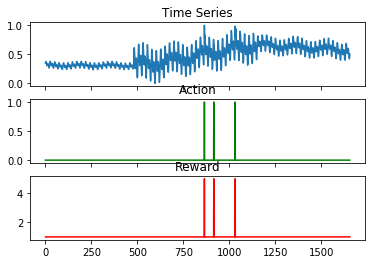

Episode 299/367


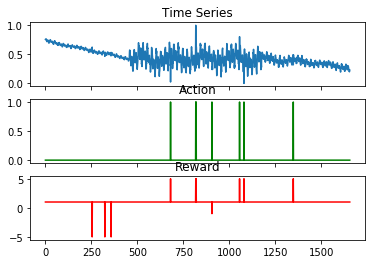

Episode 300/367


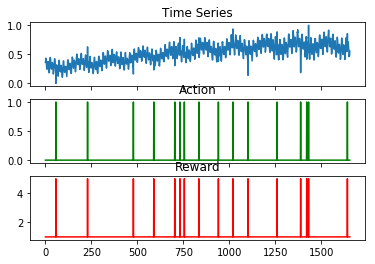

Episode 301/367


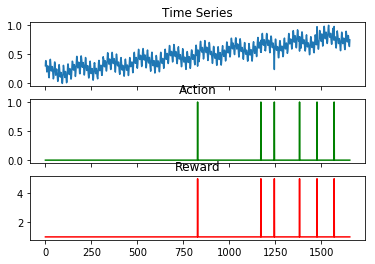

Episode 302/367


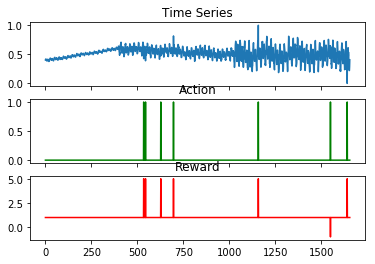

Episode 303/367


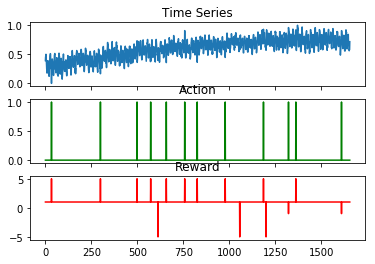

Episode 304/367


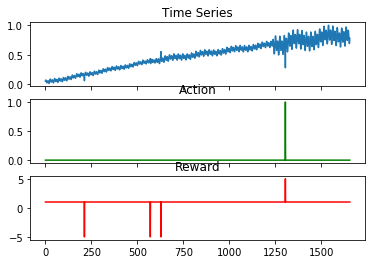

Episode 305/367


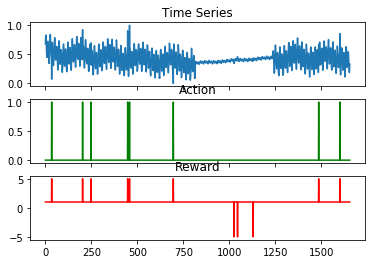

Episode 306/367


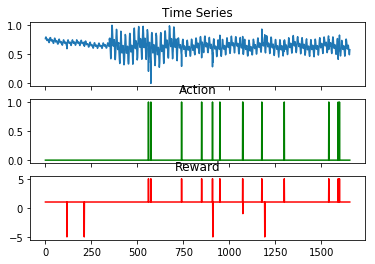

Episode 307/367


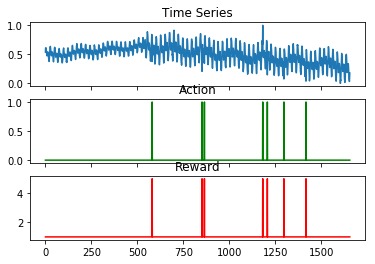

Episode 308/367


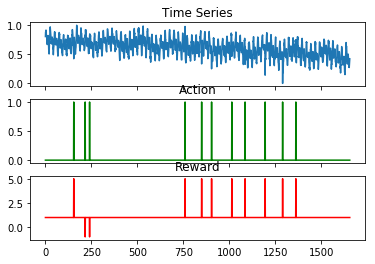

Episode 309/367


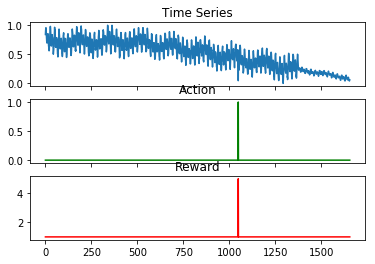

Episode 310/367


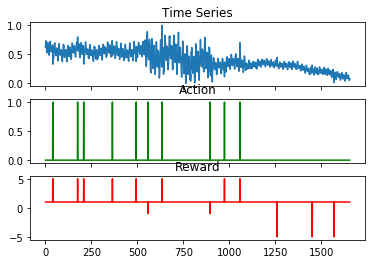

Episode 311/367


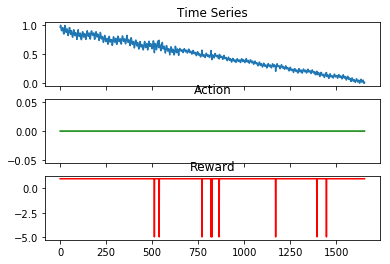

Episode 312/367


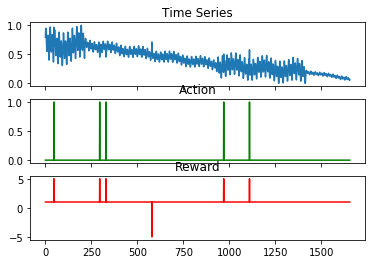

Episode 313/367


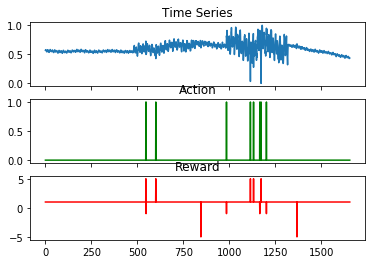

Episode 314/367


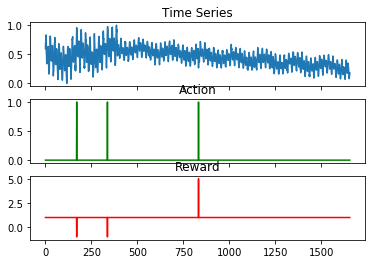

Episode 315/367


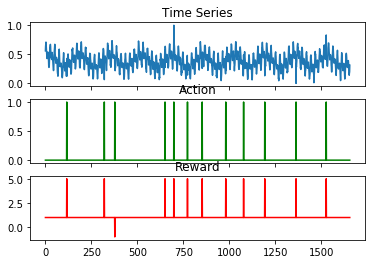

Episode 316/367


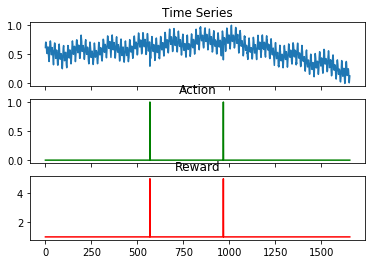

Episode 317/367


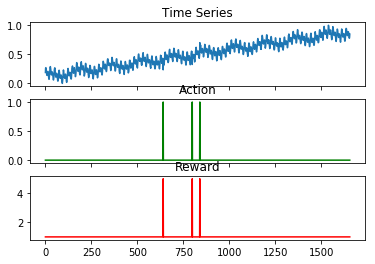

Episode 318/367


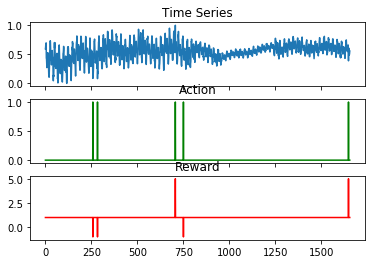

Episode 319/367


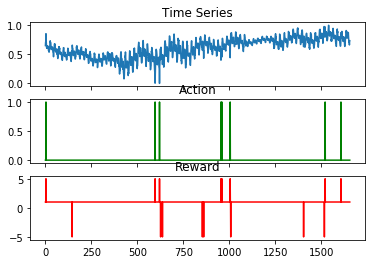

Episode 320/367


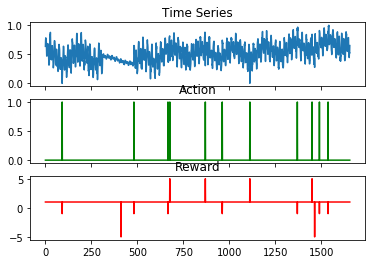

Episode 321/367


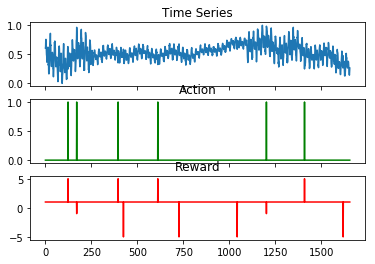

Episode 322/367


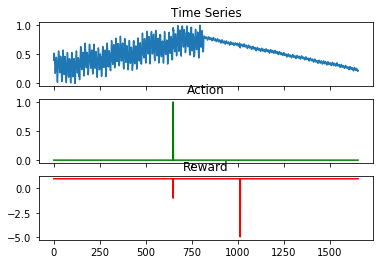

Episode 323/367


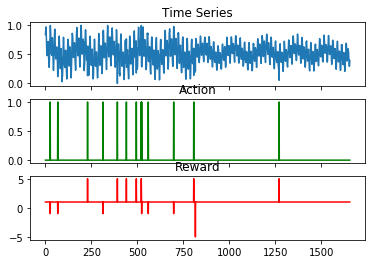

Episode 324/367


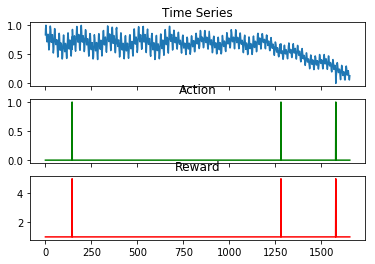

Episode 325/367


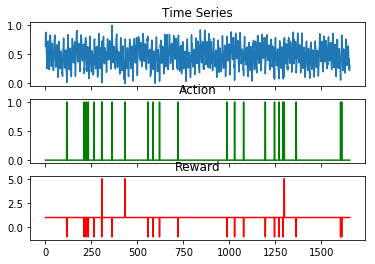

Episode 326/367


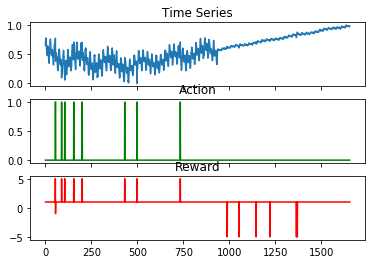

Episode 327/367


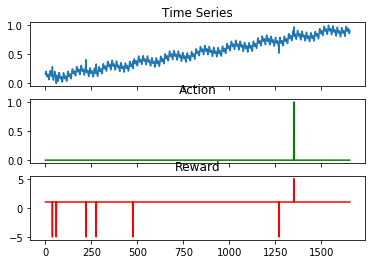

Episode 328/367


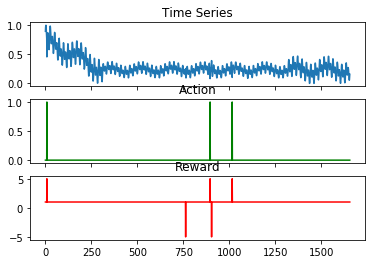

Episode 329/367


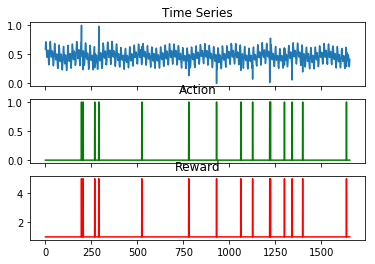

Episode 330/367


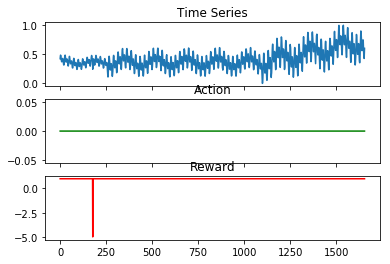

Episode 331/367


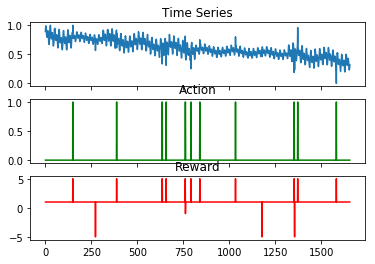

Episode 332/367


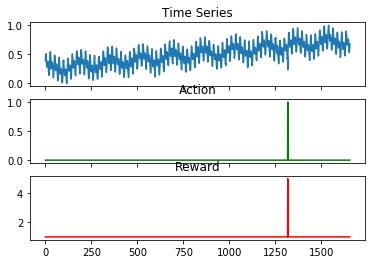

Episode 333/367


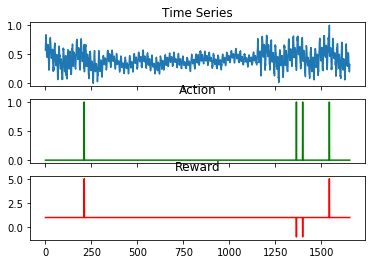

Episode 334/367


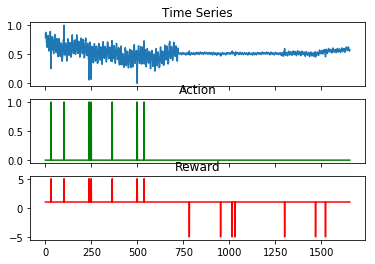

Episode 335/367


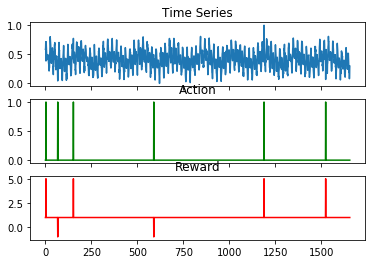

Episode 336/367


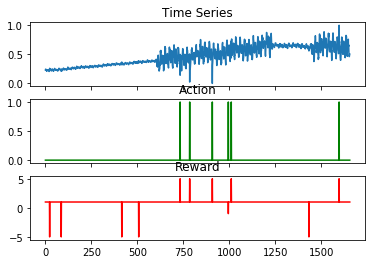

Episode 337/367


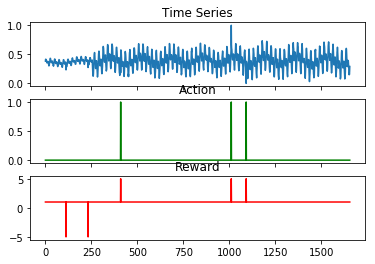

Episode 338/367


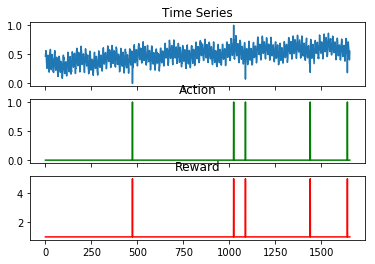

Episode 339/367


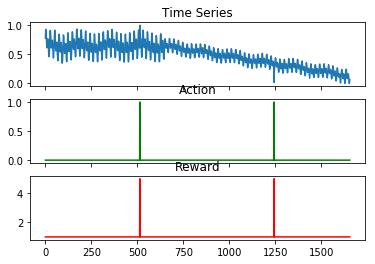

Episode 340/367


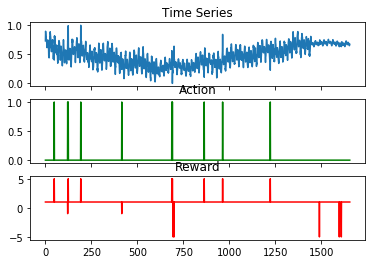

Episode 341/367


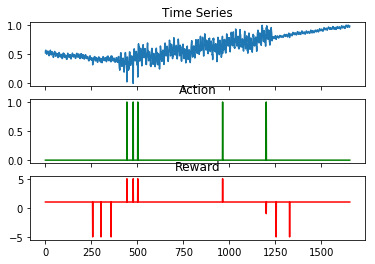

Episode 342/367


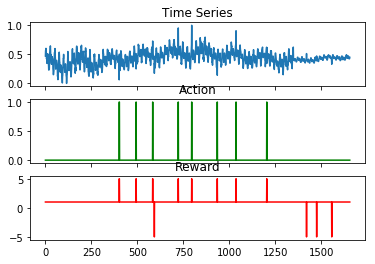

Episode 343/367


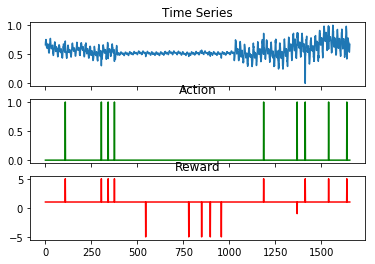

Episode 344/367


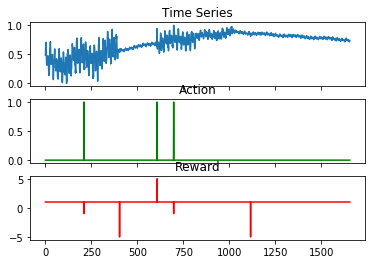

Episode 345/367


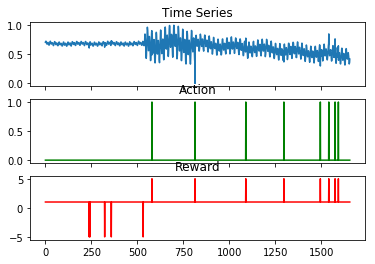

Episode 346/367


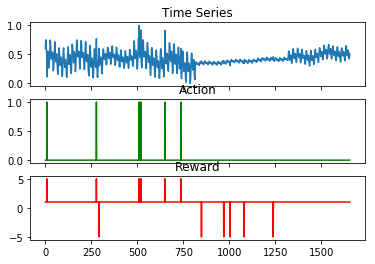

Episode 347/367


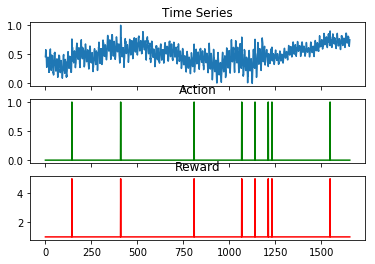

Episode 348/367


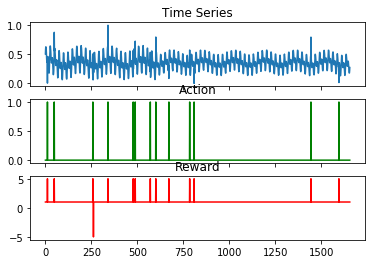

Episode 349/367


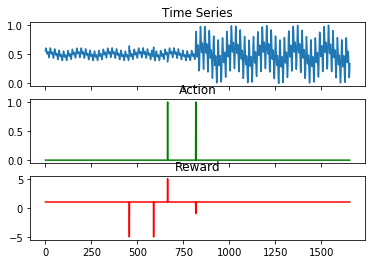

Episode 350/367


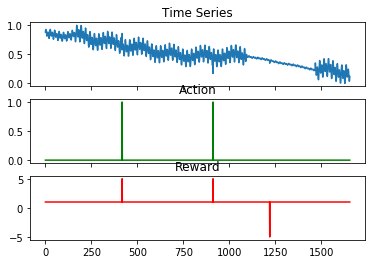

Episode 351/367


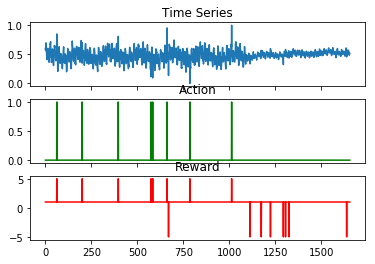

Episode 352/367


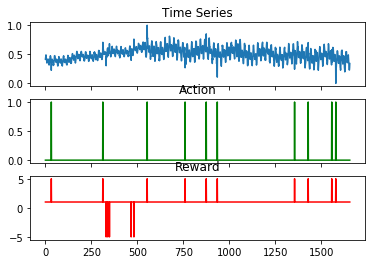

Episode 353/367


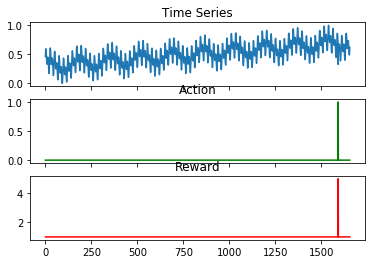

Episode 354/367


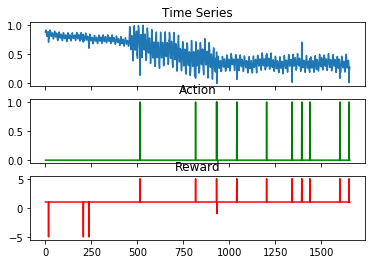

Episode 355/367


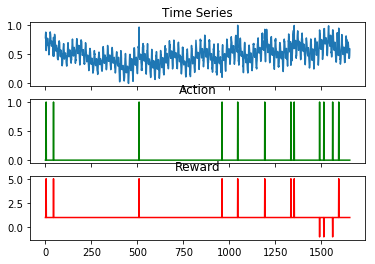

Episode 356/367


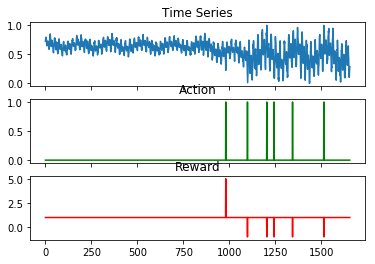

Episode 357/367


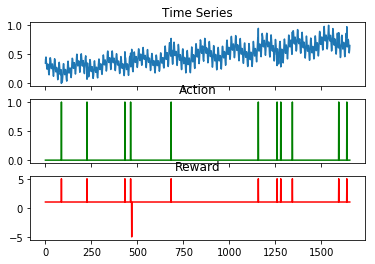

Episode 358/367


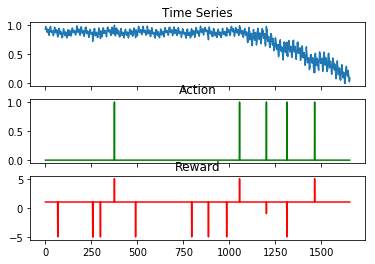

Episode 359/367


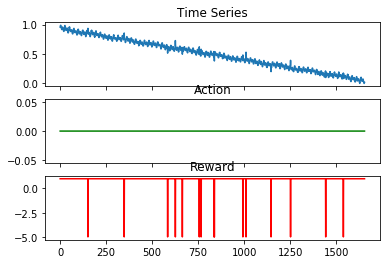

Episode 360/367


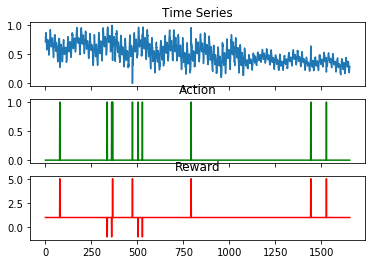

Episode 361/367


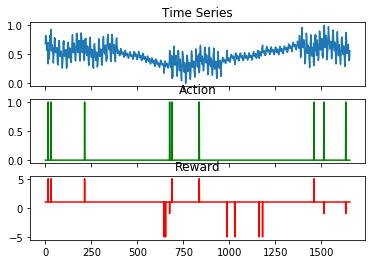

Episode 362/367


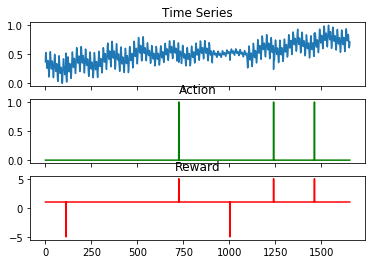

Episode 363/367


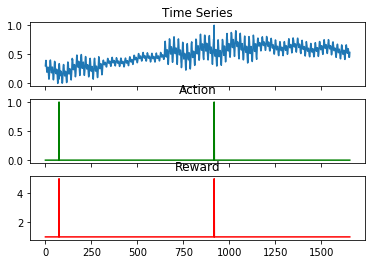

Episode 364/367


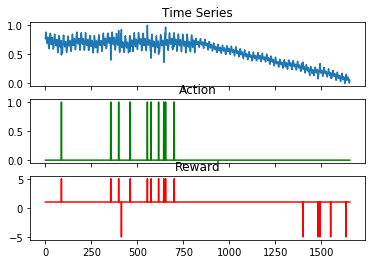

Episode 365/367


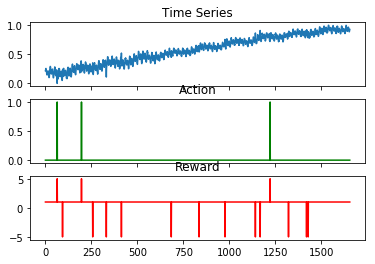

Episode 366/367


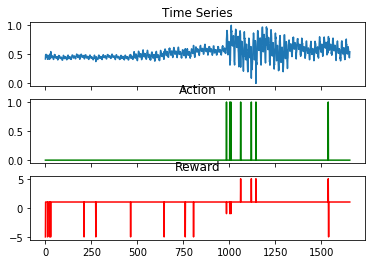

Episode 367/367


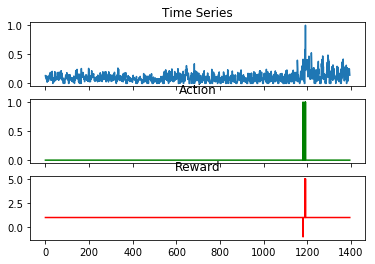

In [10]:
print env.datasetsize
env.datasetrng = env.datasetsize
env.datasetidx = 0

with sess.as_default():
    q_learning_validator(env, qlearn_estimator, env.datasetsize)